# **Q6. Business Case: Apollo Hospitals - Hypothesis Testing**

## **Problem Statement:**
### 1. Clean, sanitize and manipulate data to identify which variables are significant in predicting the reason for hospitalization for different regions.
### 2. Analyze how well some variables like viral load, smoking, Severity Level describe the hospitalization charges.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.api as sm
import pylab
import missingno as msno

In [2]:
pd.set_option('display.max_columns', None)
minmaxscaler = MinMaxScaler()
standardscaler = StandardScaler()
sns.set_theme(style="darkgrid")
continuous_types = ['float64', 'datetime64[ns]']
discrete_types = ['int64']
numeric_types = ['int64', 'float64']
categorical_types = ['category', 'bool']
get_columns_by_types = lambda df, types: [df.columns[index] for index in range(len(df.columns)) if df.dtypes[index].name in types]
right_skew_transformations = [['natural log', lambda x: np.log(x)],
                  ['log base 10', lambda x: np.log10(x)],
                 ['log base 2', lambda x: np.log2(x)],
                 ['square root', lambda x: (x)**(1/2)],
                 ['cube root', lambda x: (x)**(1/3)]]
left_skew_transformations = [['exponential', lambda x: np.exp(x)],
                 ['square', lambda x: (x)**(2)],
                 ['cube', lambda x: (x)**(3)]]

In [3]:
def convert_to_best_type(df):
    for column in df.columns:
        try:
            if np.any(df[column].apply(lambda x: '.' in str(x))):
                df[column] = df[column].astype('float64')
            else:
                if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                    df[column] = df[column].astype(bool)
                elif len(df[column].unique())<10:
                    df[column] = pd.Categorical(df[column])
                else:
                    df[column] = df[column].astype('int64')
        except:
            if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                df[column] = df[column].astype(bool)
            elif np.any(df[column].apply(lambda x: ':' in str(x))):
                df[column] = pd.to_datetime(df[column])
            elif len(df[column].unique())<10:
                df[column] = pd.Categorical(df[column])
            else:
                df[column] = df[column].astype('string')
    return df

In [4]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    outlier_fraction = (len(df_in)-len(df_out))/len(df_in)
    if outlier_fraction > 0.0:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(18,6))
        sns.boxplot(data=df_in, y=col_name)
        if outlier_fraction <= 0.10:
            fig.suptitle(f"Outliers constitute {round(outlier_fraction*100, 2)}% of data for column '{col_name}'. Hence removing outliers.", fontsize=20, color="green")
            plt.show()
            return df_out
        else:
            fig.suptitle(f"Outliers constitute significant amount of data ({round(outlier_fraction*100, 2)}%) for column '{col_name}'. Hence not removing outliers..", fontsize=20, color="green")
            plt.show()
            return df_in
    else:
        return df_in

***
***
## **1. Analyzing Basic Metrics.**

In [5]:
df = pd.read_csv(r"https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/681/original/scaler_apollo_hospitals.csv")
df = convert_to_best_type(df)
df.head()

,Unnamed: 0,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,0,19,female,yes,southwest,9.30,0,42212
1,1,18,male,no,southeast,11.26,1,4314
2,2,28,male,no,southeast,11.00,3,11124
3,3,33,male,no,northwest,7.57,0,54961
4,4,32,male,no,northwest,9.63,0,9667


In [6]:
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.30,0,42212
1,18,male,no,southeast,11.26,1,4314
2,28,male,no,southeast,11.00,3,11124
3,33,male,no,northwest,7.57,0,54961
4,32,male,no,northwest,9.63,0,9667


In [7]:
print("Shape:", df.shape, "\n")

Shape: (1338, 7) 



In [8]:
df.describe()

,age,viral load,hospitalization charges
count,1338.000000,1338.000000,1338.000000
mean,39.207025,10.221233,33176.058296
std,14.049960,2.032796,30275.029296
min,18.000000,5.320000,2805.000000
25%,27.000000,8.762500,11851.000000
50%,39.000000,10.130000,23455.000000
75%,51.000000,11.567500,41599.500000
max,64.000000,17.710000,159426.000000


In [9]:
df.dtypes

age                           int64
sex                        category
smoker                     category
region                     category
viral load                  float64
severity level             category
hospitalization charges       int64
dtype: object

***
***
## **2. Missing Values, Duplicates and Unique values check**

### 2.1 Missing Values

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      1338 non-null   int64   
 1   sex                      1338 non-null   category
 2   smoker                   1338 non-null   category
 3   region                   1338 non-null   category
 4   viral load               1338 non-null   float64 
 5   severity level           1338 non-null   category
 6   hospitalization charges  1338 non-null   int64   
dtypes: category(4), float64(1), int64(2)
memory usage: 37.4 KB


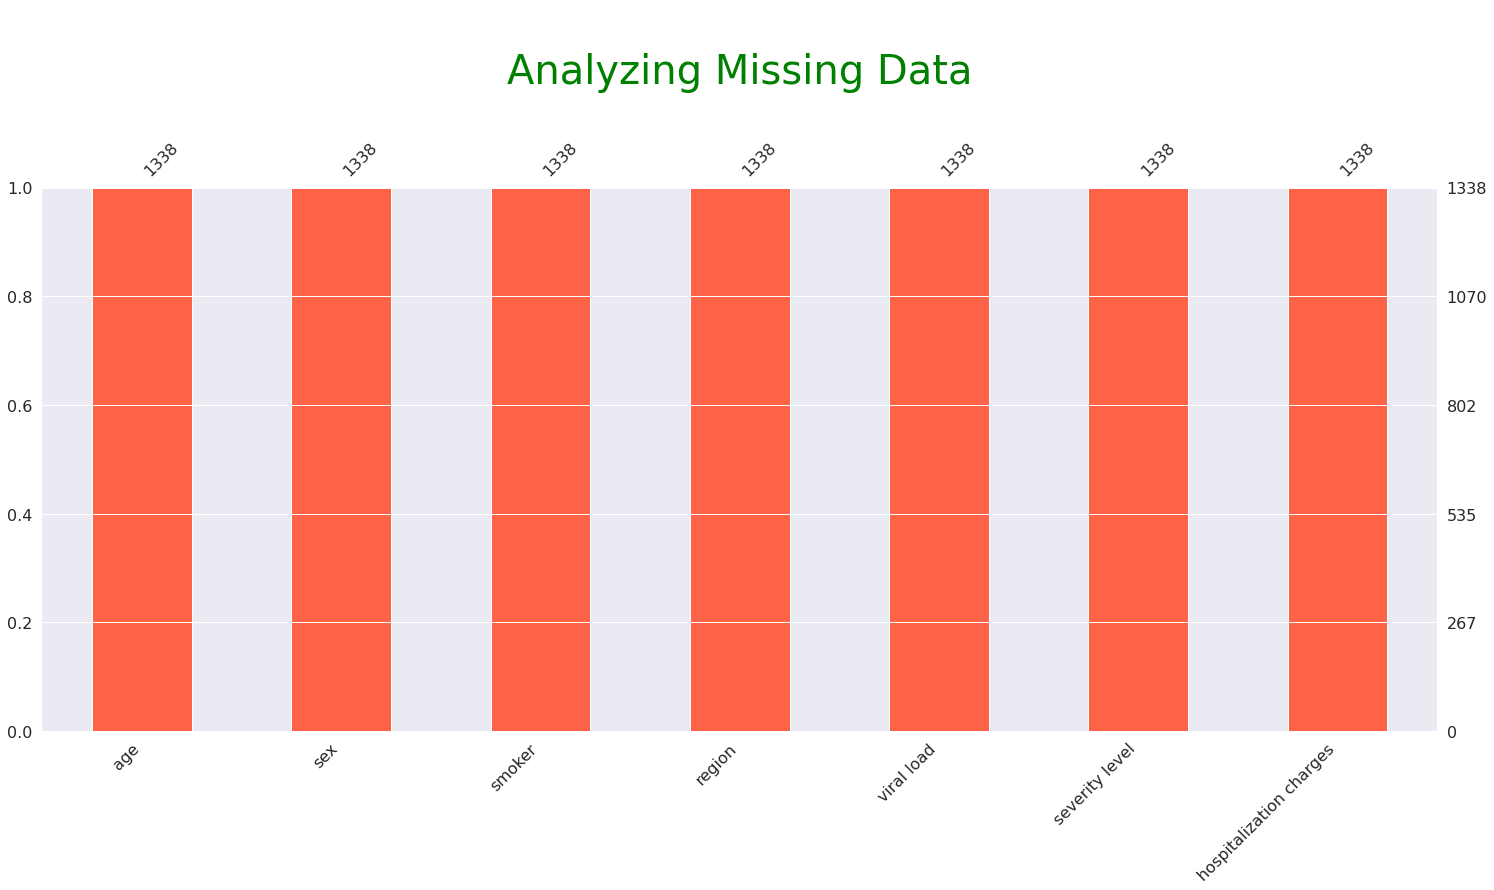

In [11]:
msno.bar(df, color='tomato')
plt.title("\nAnalyzing Missing Data\n", fontsize=40, color="green")
plt.show()

**Observations**
- There are no missing values in the dataset

### 2.2 Check for Duplicates

In [12]:
print("Number of duplicates: {}".format(df.duplicated().sum()))

Number of duplicates: 1


### 2.3 Check for Unique values in each column

In [13]:
for col in df.columns:
    print("{:15}: {}".format(col, df[col].nunique()))


age            : 47
sex            : 2
smoker         : 2
region         : 4
viral load     : 462
severity level : 6
hospitalization charges: 1320


### 2.4 Change in datatype

In [14]:
df['severity level'] = df['severity level'].astype('object')

***
***
## **3. Outlier Detection & Treatment.**

In [15]:
df.describe()

,age,viral load,hospitalization charges
count,1338.000000,1338.000000,1338.000000
mean,39.207025,10.221233,33176.058296
std,14.049960,2.032796,30275.029296
min,18.000000,5.320000,2805.000000
25%,27.000000,8.762500,11851.000000
50%,39.000000,10.130000,23455.000000
75%,51.000000,11.567500,41599.500000
max,64.000000,17.710000,159426.000000


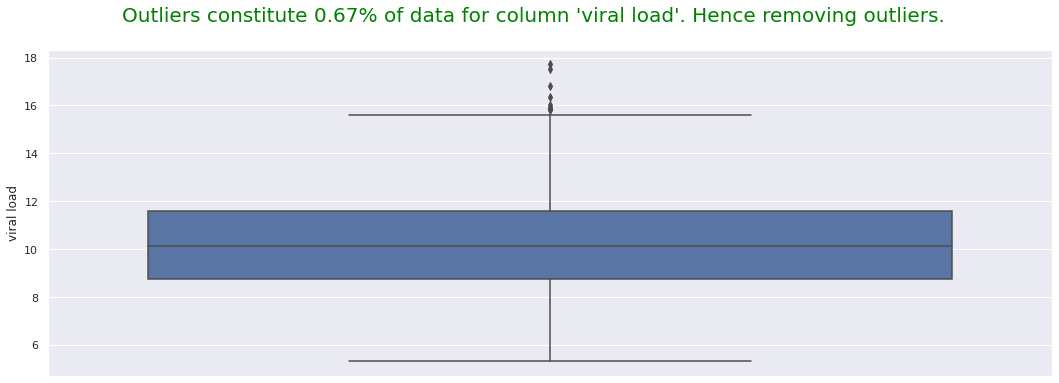

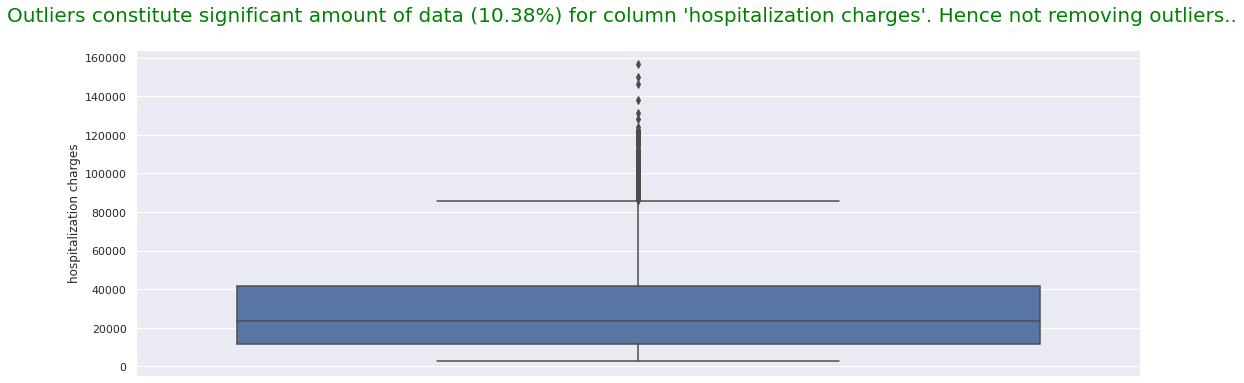

In [16]:
for column in get_columns_by_types(df, numeric_types):
    df = remove_outlier(df, column)

**Observations**
- viral load and hospitalization charges have outliers.

***
***
## **4. Univariate Analysis**

### 4.1 Univariate Analysis (Categorical Data)

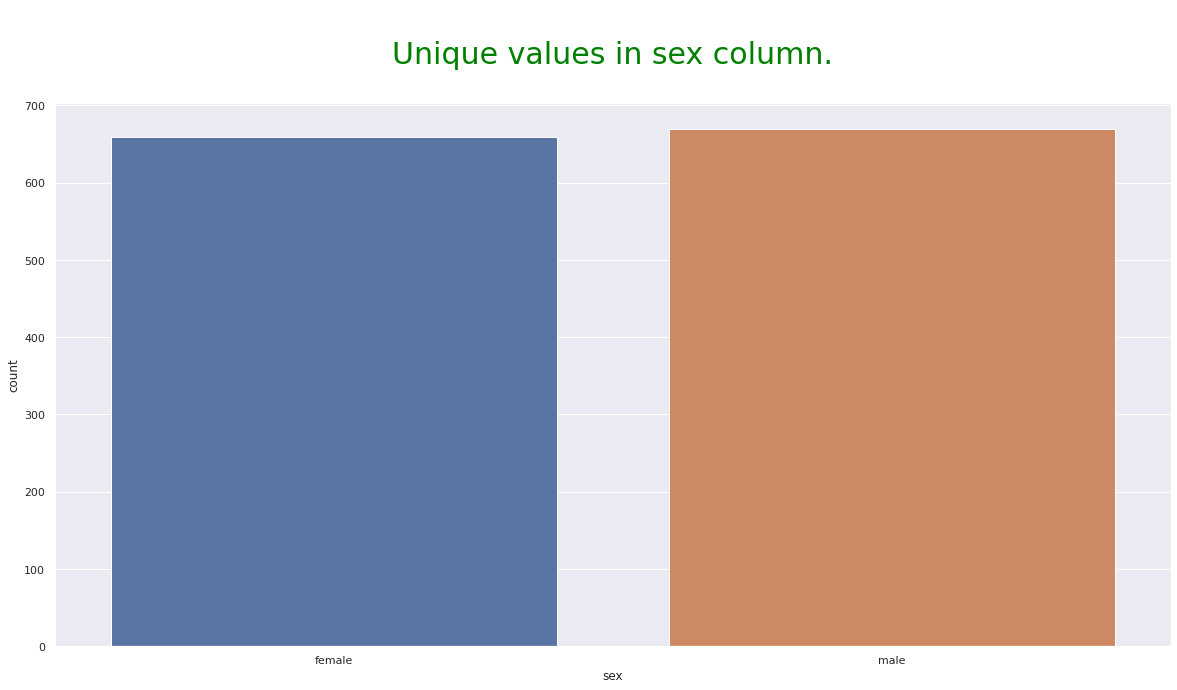

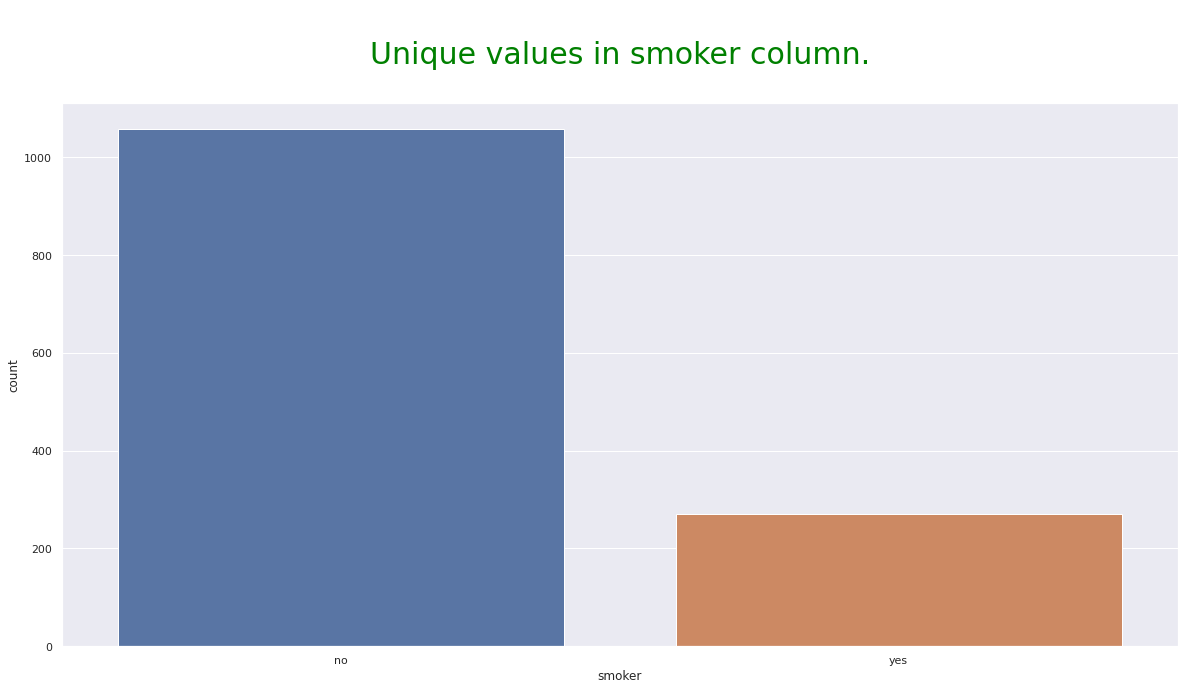

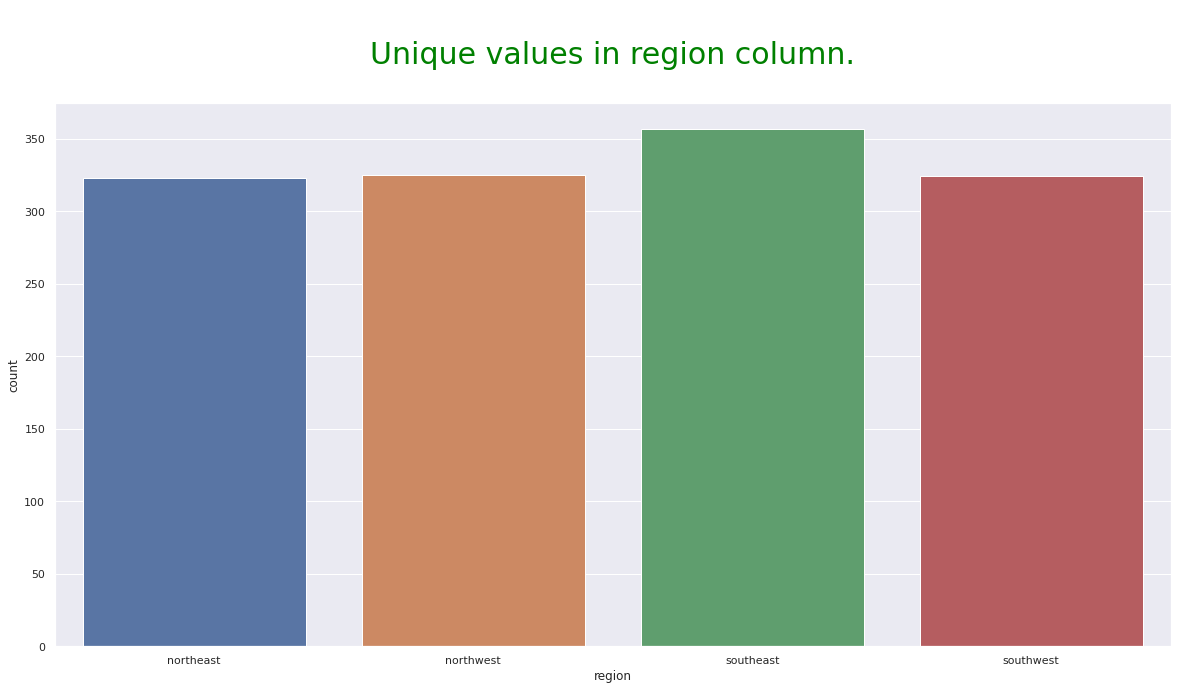

In [17]:
for column in get_columns_by_types(df, categorical_types):
    fig, axes = plt.subplots(figsize=(20, 10))
    sns.countplot(data=df, x=column)
    plt.title(f"\nUnique values in {column} column.\n", fontsize=30, color="green")
    plt.show()

**Observations**
- The sex & region have almost equal number of values in each category.
- Most of the patients are non-smoker.
- Number of patients decreses as severity level increses.

***
***
### 4.2 Univariate Analysis (Discrete Data)

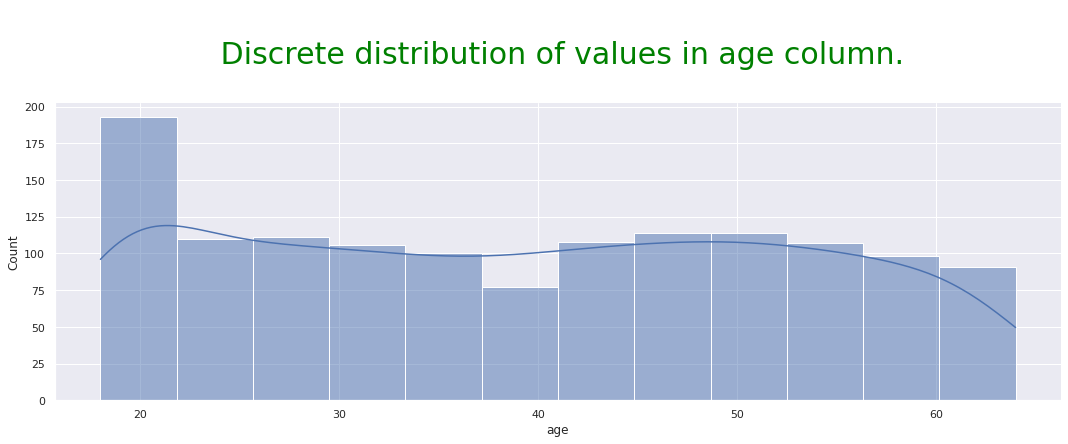

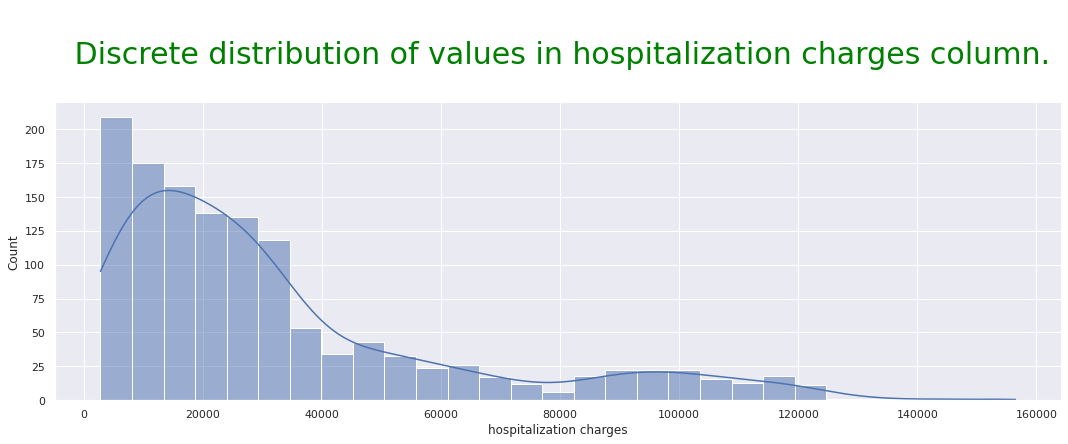

In [18]:
for column in get_columns_by_types(df, discrete_types):
    sns.displot(df[column], kde=True, height=5, aspect=3)
    plt.title(f"\n Discrete distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
### 4.3 Univariate Analysis (Continuous Data)

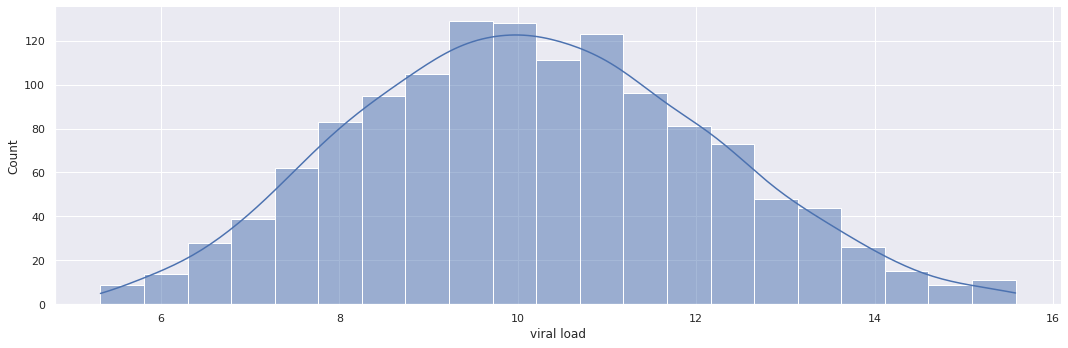

In [19]:
for column in get_columns_by_types(df, continuous_types):
    sns.displot(df[column], kde=True, height=5, aspect=3)
     

**Observations**
- **age**: Follows somewhat uniform distribution
- **hospitalization charges**: is right skewed
- **viral load**: Looks like the normal distribution

***
***
## **5. Bivariate Analysis.**

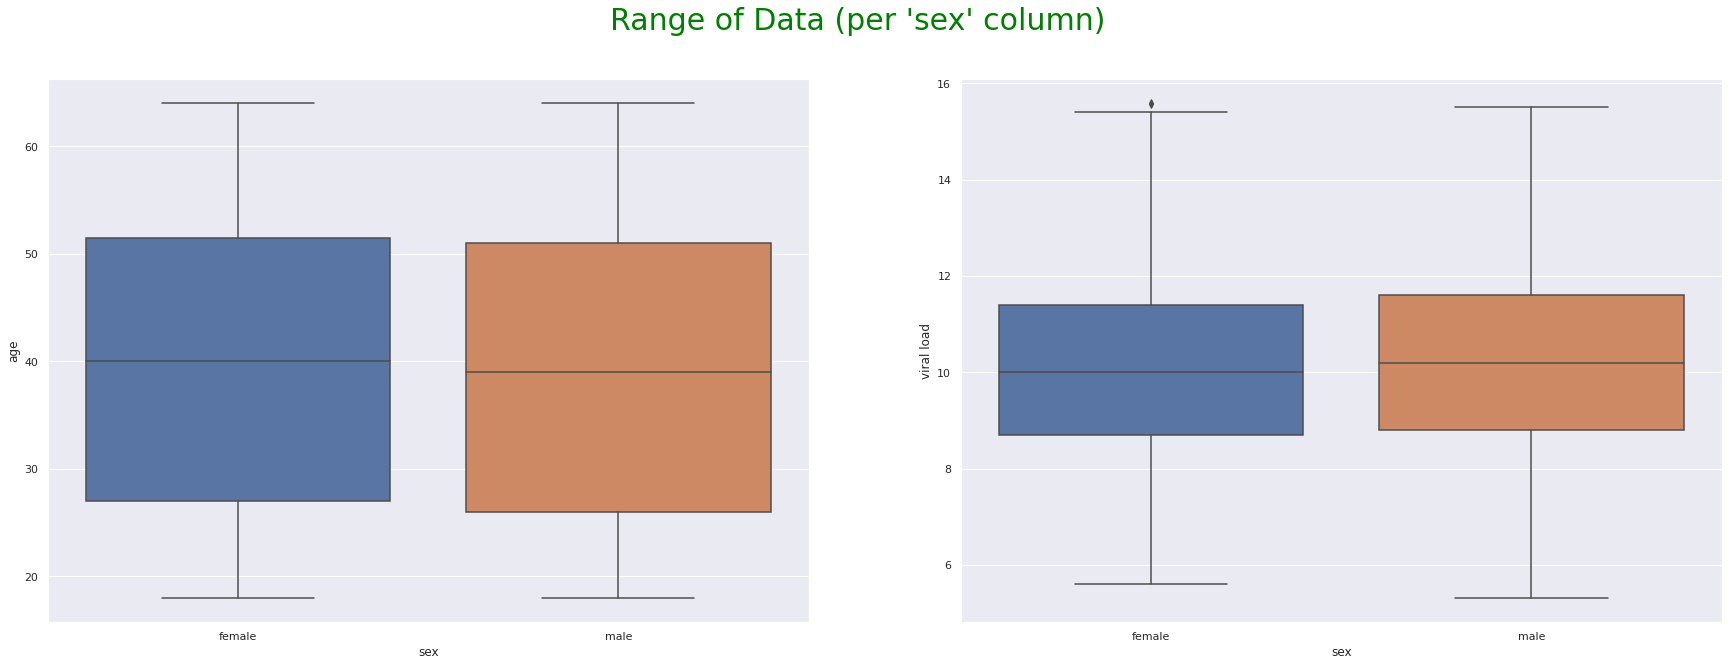

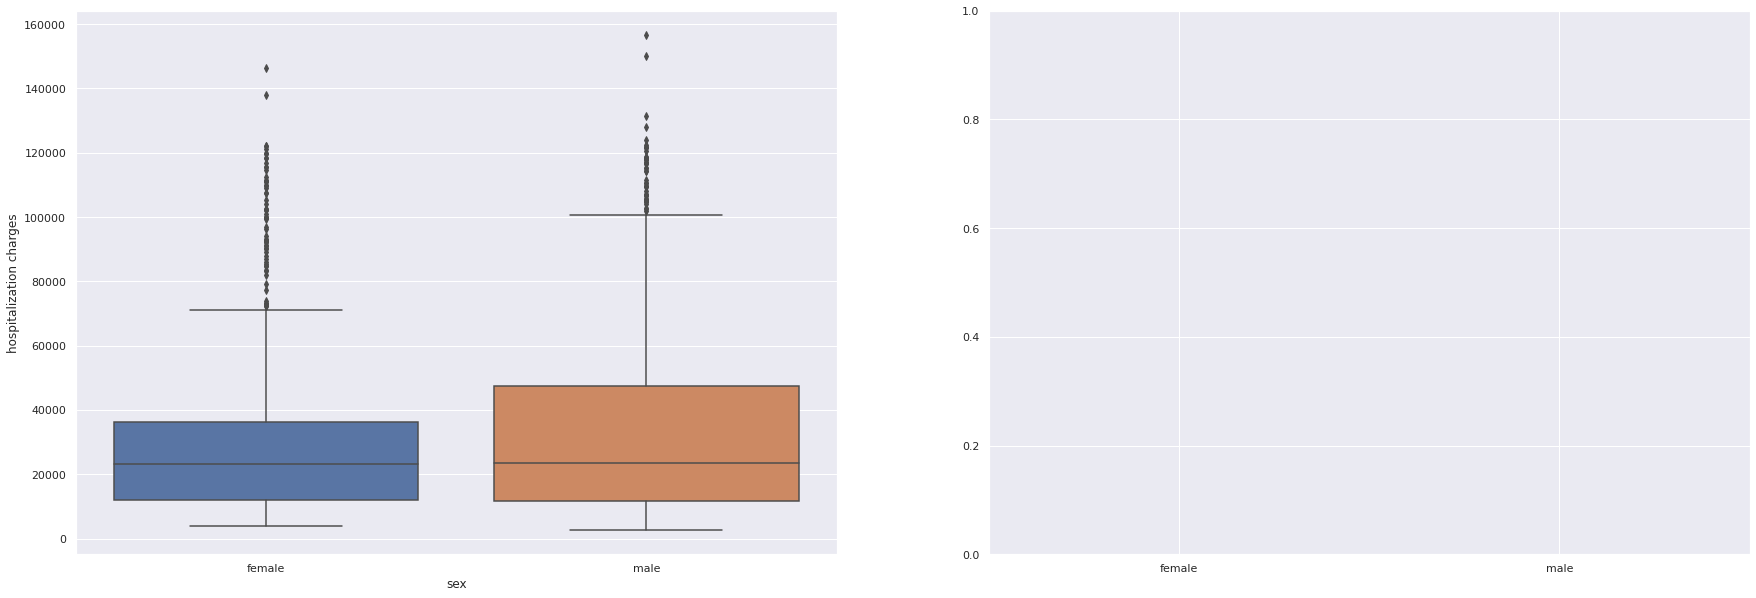

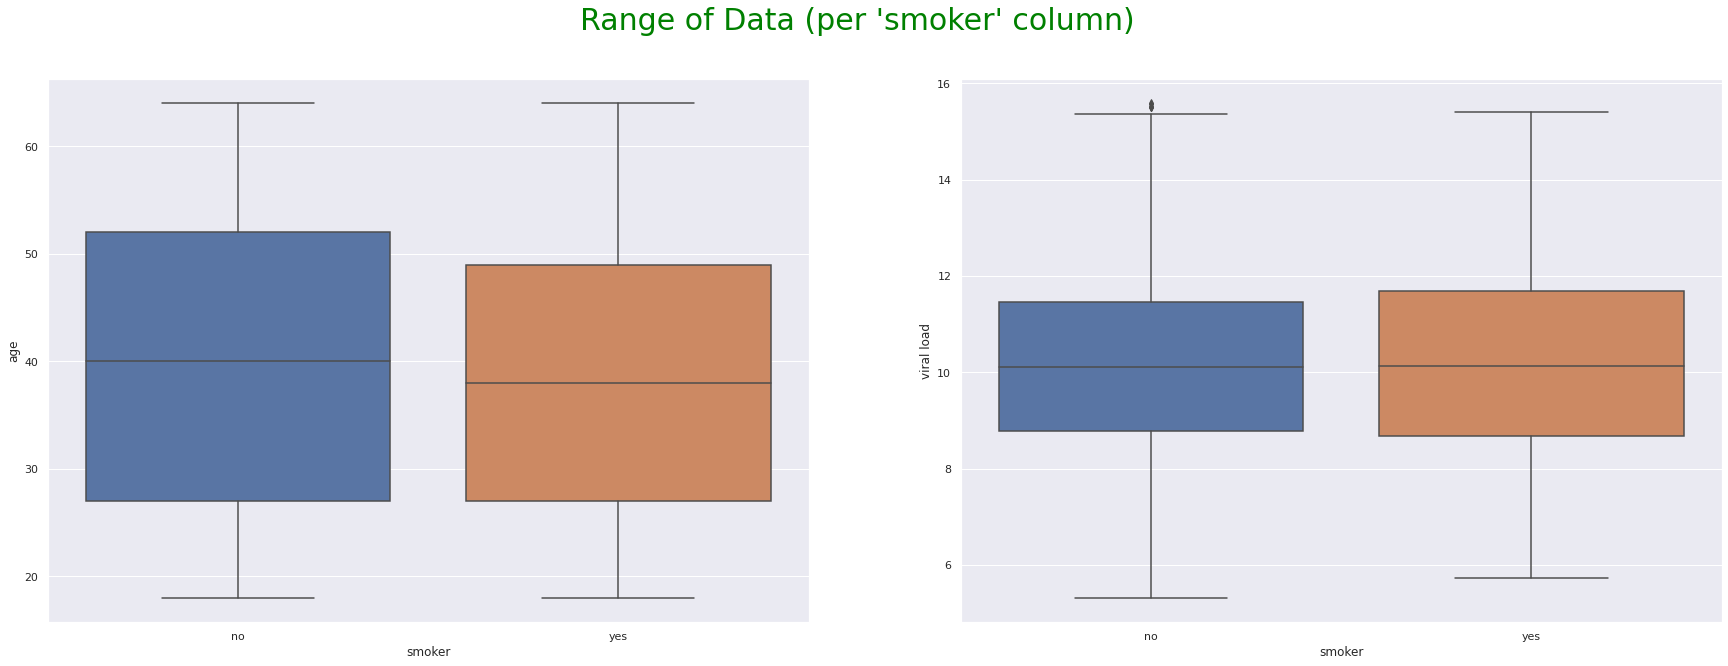

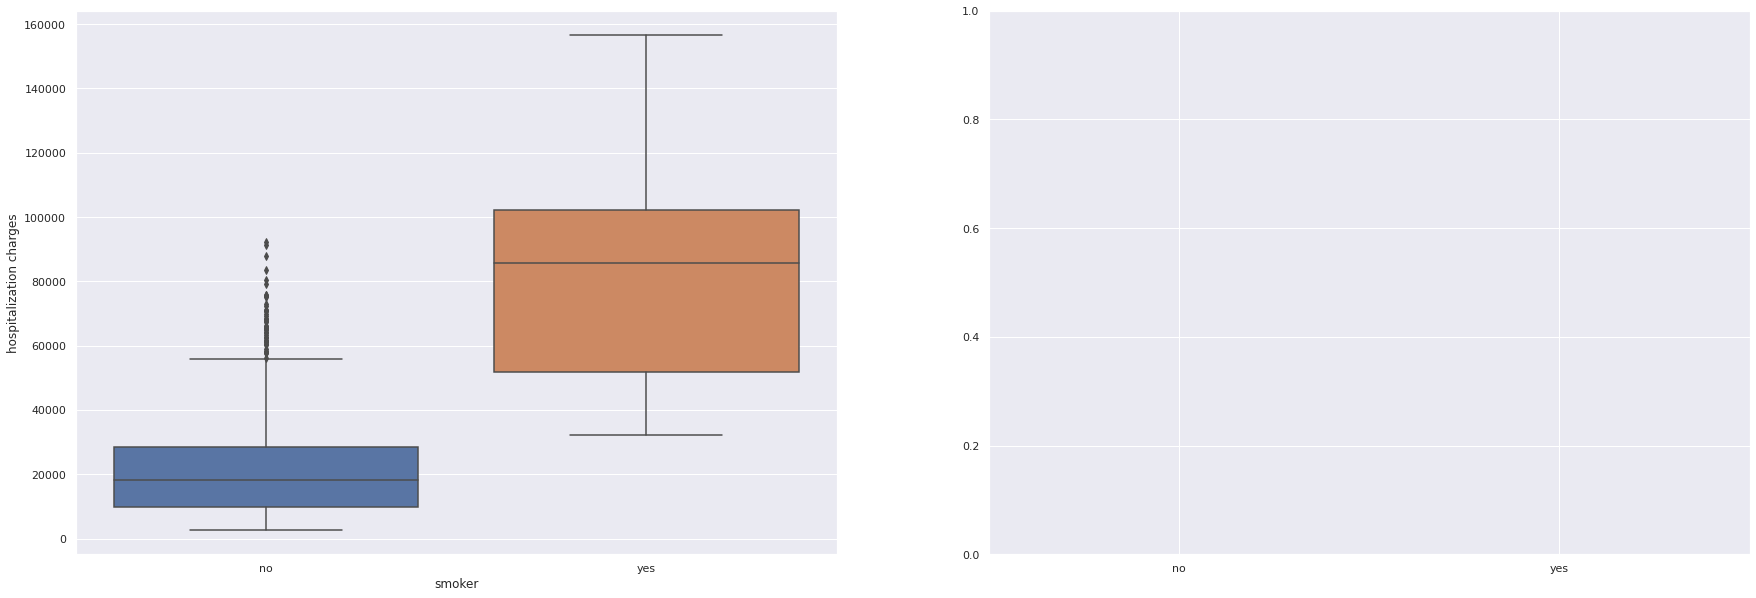

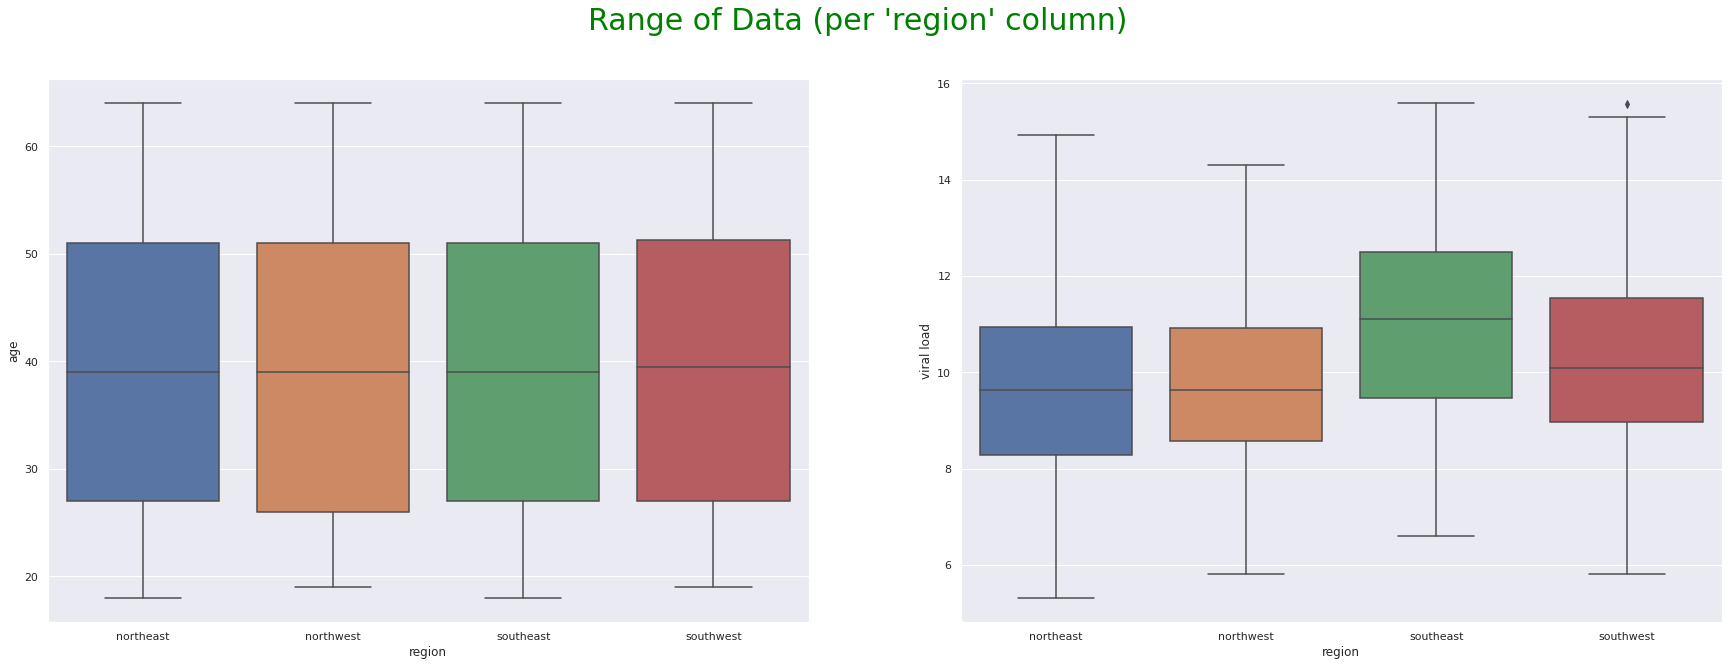

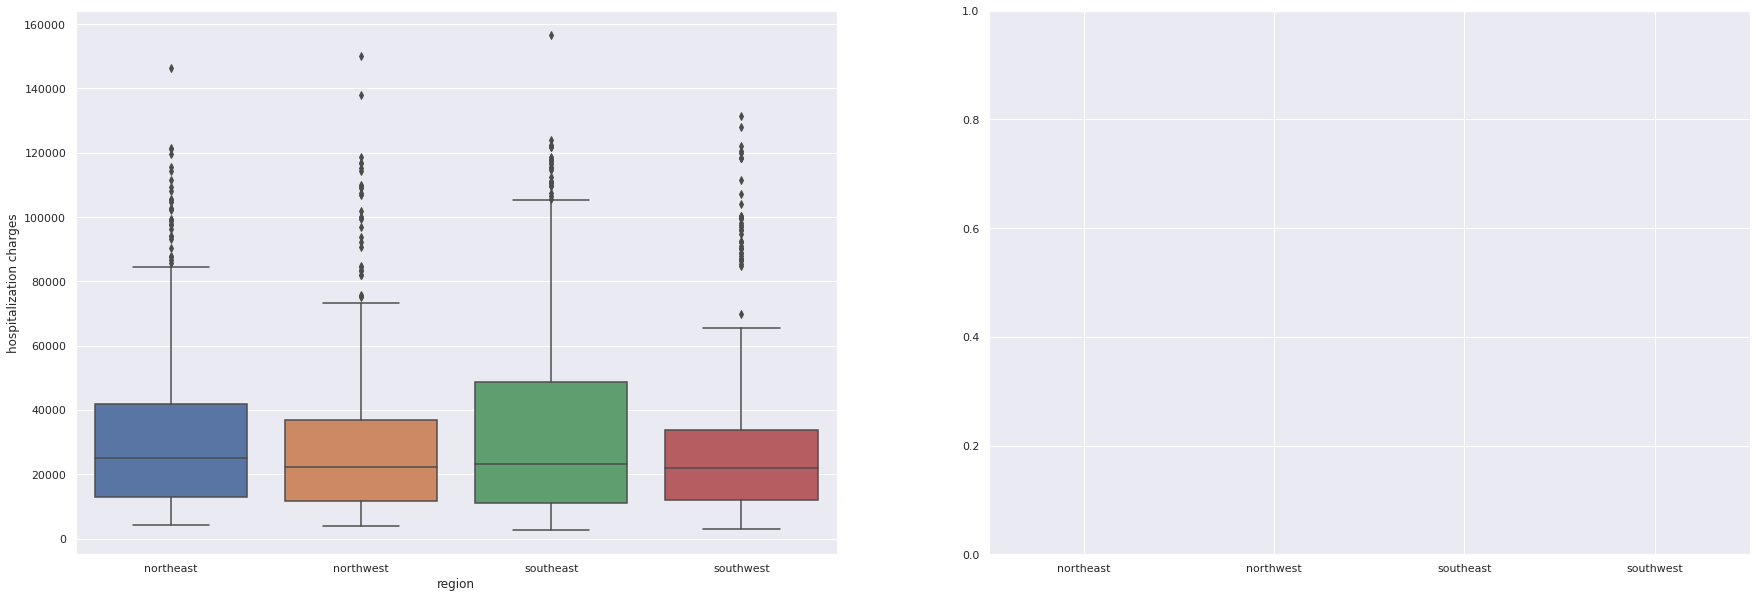

In [20]:
for category in get_columns_by_types(df, categorical_types):
    column_index = 0
    while column_index < len(get_columns_by_types(df, numeric_types)) :
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(30, 10))
        if  column_index == 0:
            fig.suptitle(f"Range of Data (per '{category}' column)", fontsize=30, color="green")
        sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[0], x=category)
        column_index += 1
        if column_index < len(get_columns_by_types(df, numeric_types)):
            sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[1], x=category)
            column_index += 1
        plt.show()

**Observations**

- It is quite evident from the charts that smoker patients will have high hospitalization charges.
- After comparing the medians for sex, seems like both genders have similar hospitalization charges. (Will validation using hypothesis testing)
- Patients living in southeast and northeast, have slightly higher hospitalization charges as compared to southweat and northwest respectively.
- As severity level increses from 1 to 5, hospitalization charges also increses.

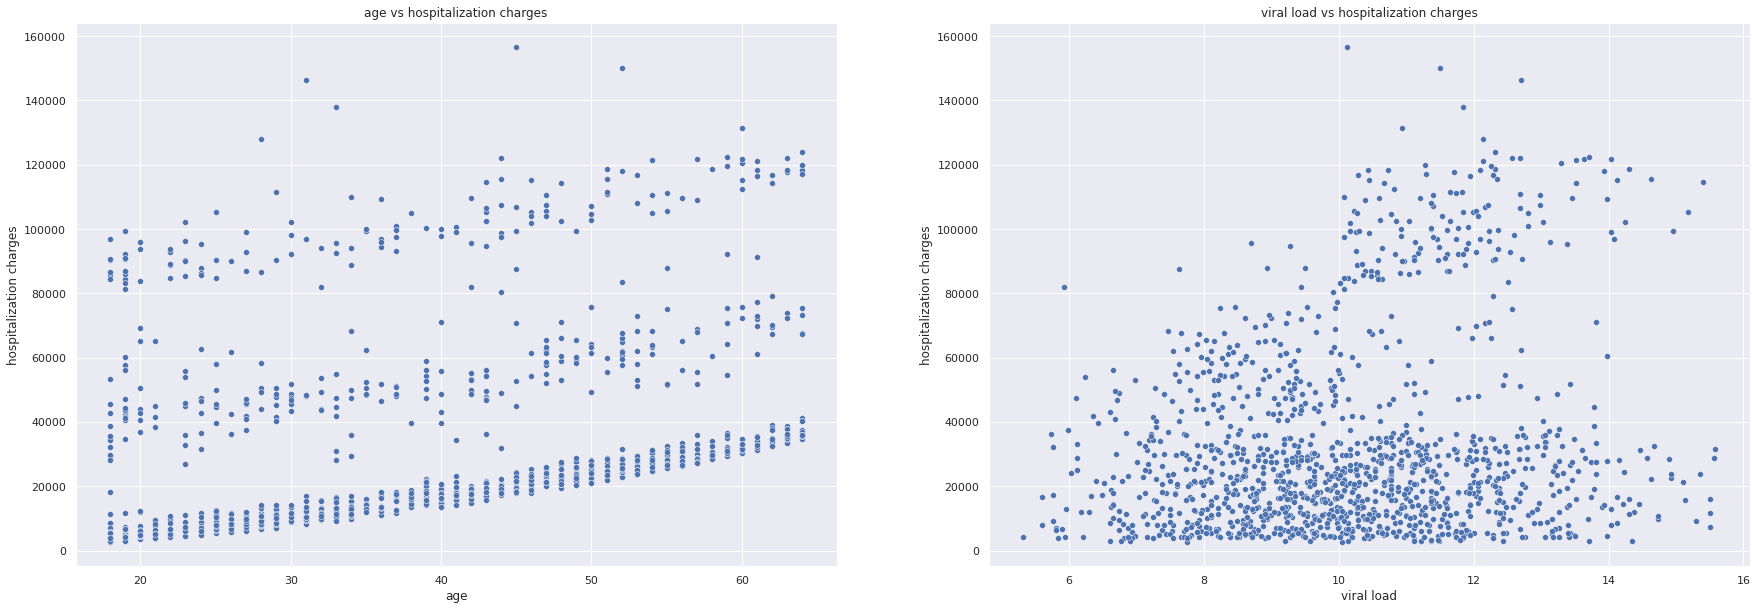

In [21]:
num_cols = ['age', 'viral load']
target = "hospitalization charges"
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
index = 0
for i in range(2):
    sns.scatterplot(y=target, x=num_cols[index], data=df, ax=axs[i])
    axs[i].set_title("{} vs hospitalization charges".format(num_cols[index]))
    index += 1 
plt.show()

**Observation**
- There seems to be a slight correlation between hospitalization charges (in different ranges) and age
- There seems to be no correlation between hospitalization charges and viral load

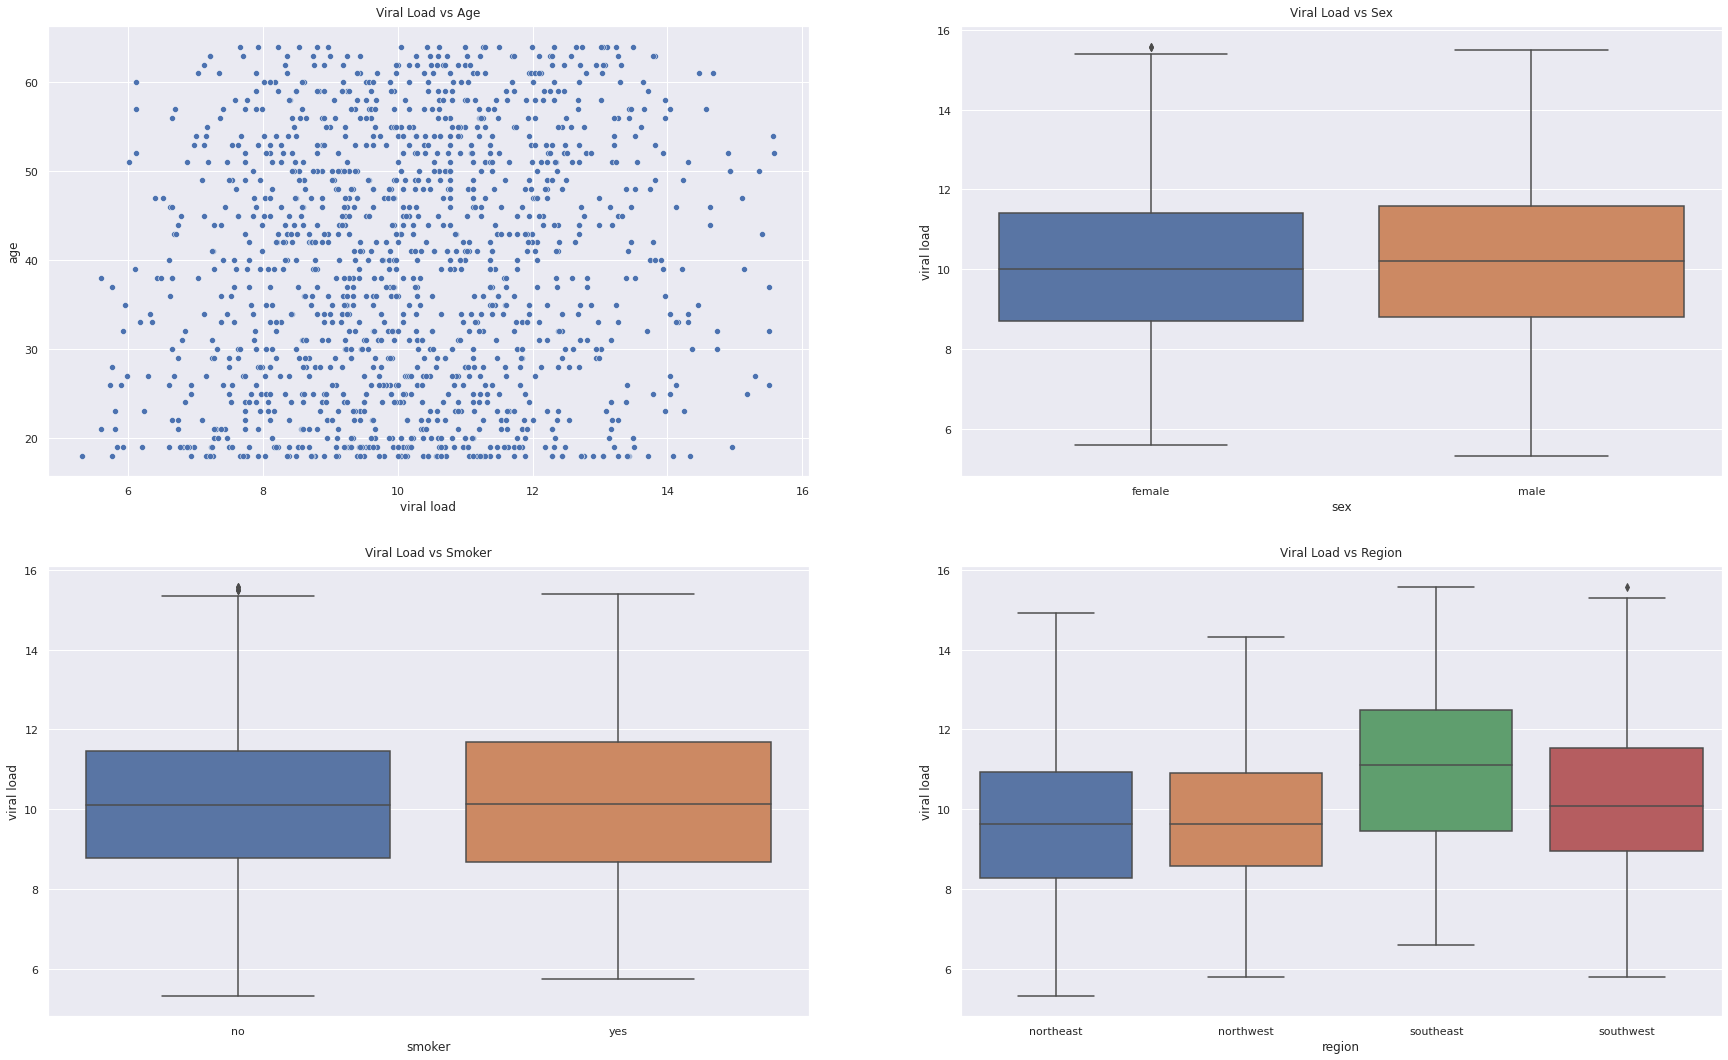

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 10))
plt.subplots_adjust(top=1.5)

sns.scatterplot(x='viral load', y='age', data=df, ax=axs[0,0])
sns.boxplot(y='viral load', x='sex', data=df, ax=axs[0,1])
sns.boxplot(y='viral load', x='smoker', data=df, ax=axs[1,0])
sns.boxplot(y='viral load', x='region', data=df, ax=axs[1,1])

axs[0,0].set_title("Viral Load vs Age", pad=10)
axs[0,1].set_title("Viral Load vs Sex", pad=10)
axs[1,0].set_title("Viral Load vs Smoker", pad=10)
axs[1,1].set_title("Viral Load vs Region", pad=10)
plt.show()

**Observations**
- Seems like viral load is not related to varibales age, sex and smoker
- Patients from southwest have higher viral load as compared to other regions.

***
***
## **6. Analysis of Correlation Between Data.**

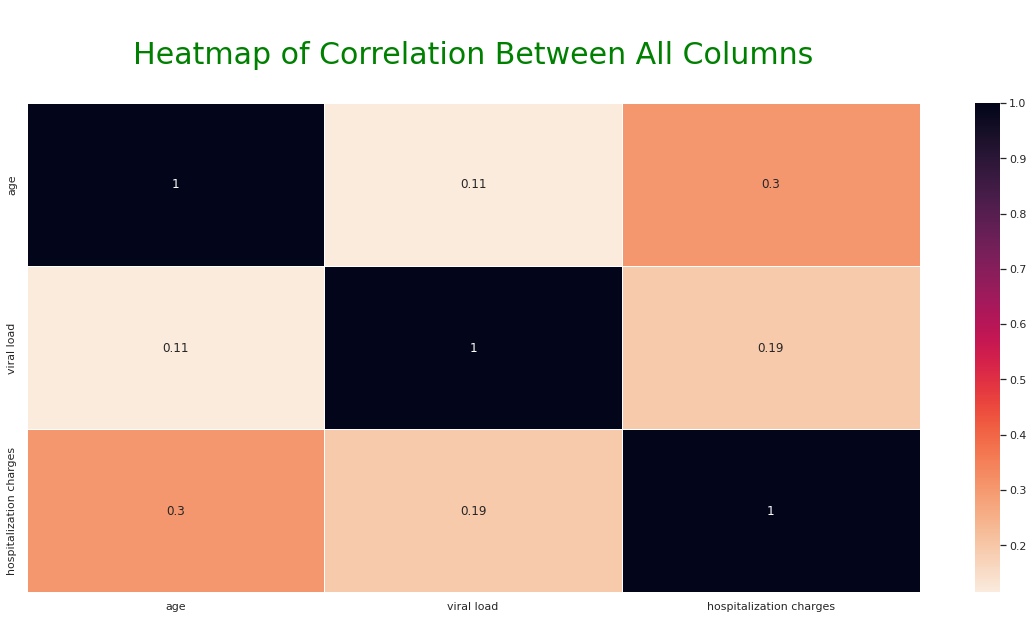

In [23]:
fig, ax = plt.subplots(figsize=(20,9))
sns.heatmap(df.corr(), linewidths=.5, cmap=sns.cm.rocket_r, annot=True, ax=ax)
plt.title("\nHeatmap of Correlation Between All Columns\n", fontsize=30, color="green")
plt.show()

***
***
## **7. Multivariate Analysis**

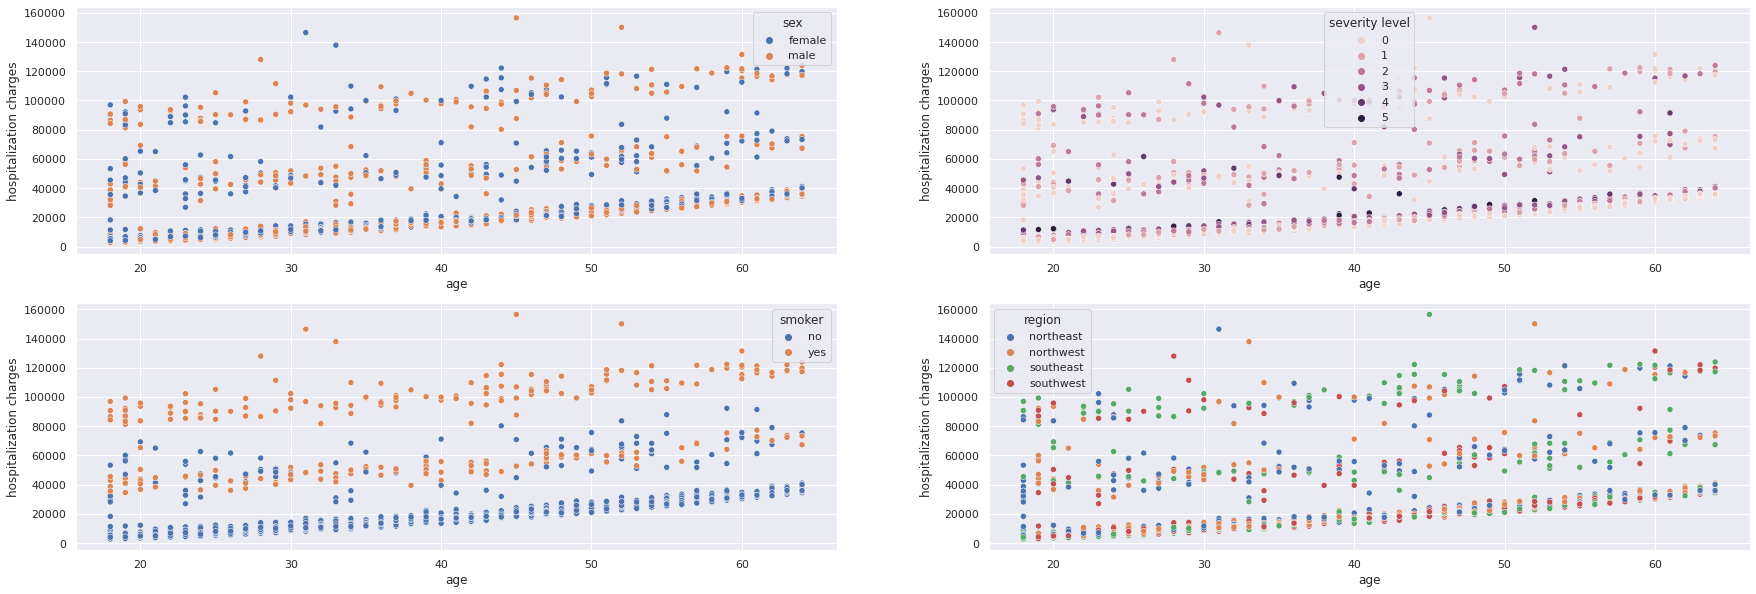

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 10))

sns.scatterplot(y=target, x='age', data=df, hue='sex', ax=axs[0, 0])
sns.scatterplot(y=target, x='age', data=df, hue='severity level', ax=axs[0,1])
sns.scatterplot(y=target, x='age', data=df, hue='smoker', ax=axs[1,0])
sns.scatterplot(y=target, x='age', data=df, hue='region', ax=axs[1,1])
plt.show()

**Observation**
- There is no any specific patterns, only distinguishes clearly that smoker patients will have high hospitalization charges.

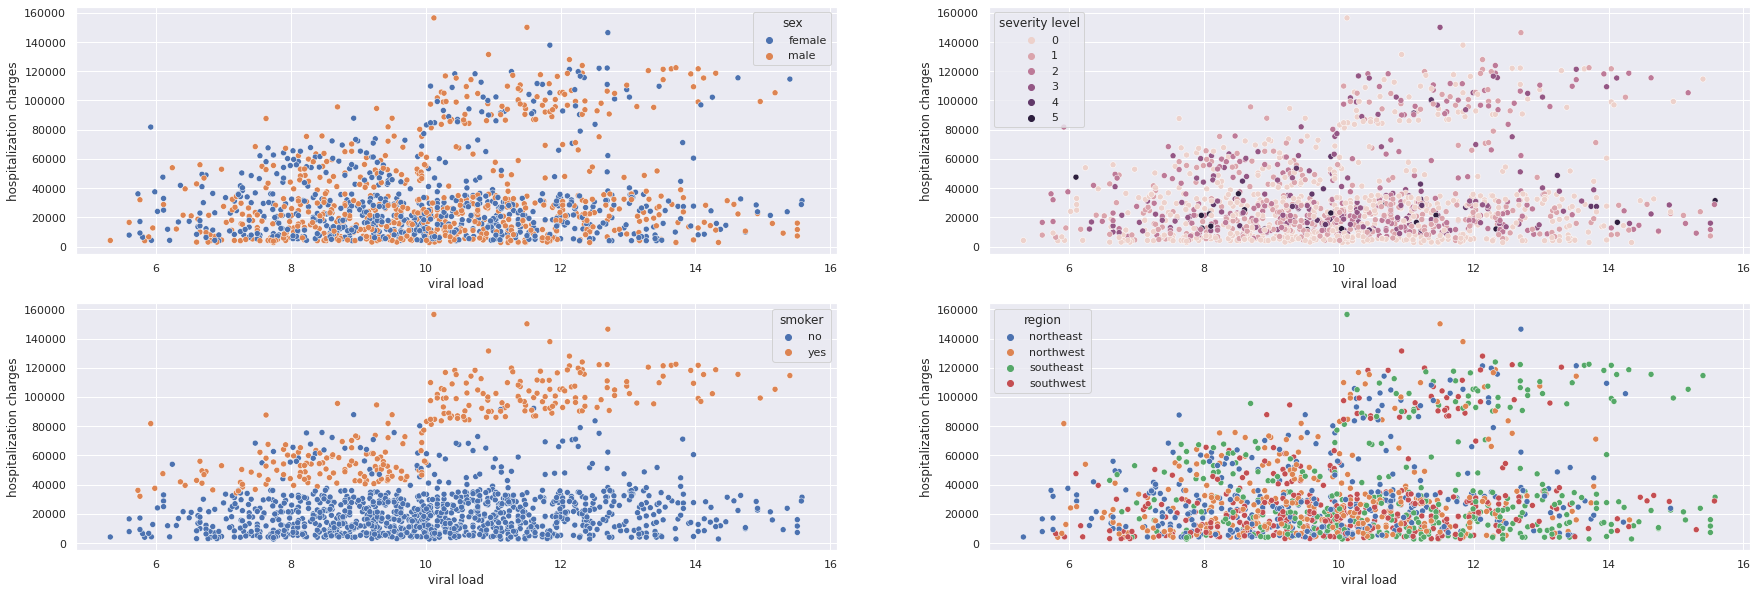

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 10))

sns.scatterplot(y=target, x='viral load', data=df, hue='sex', ax=axs[0, 0])
sns.scatterplot(y=target, x='viral load', data=df, hue='severity level', ax=axs[0,1])
sns.scatterplot(y=target, x='viral load', data=df, hue='smoker', ax=axs[1,0])
sns.scatterplot(y=target, x='viral load', data=df, hue='region', ax=axs[1,1])
plt.show()

**Observation**
- There is no any specific patterns, only distinguishes clearly that smoker patients will have high hospitalization charges.

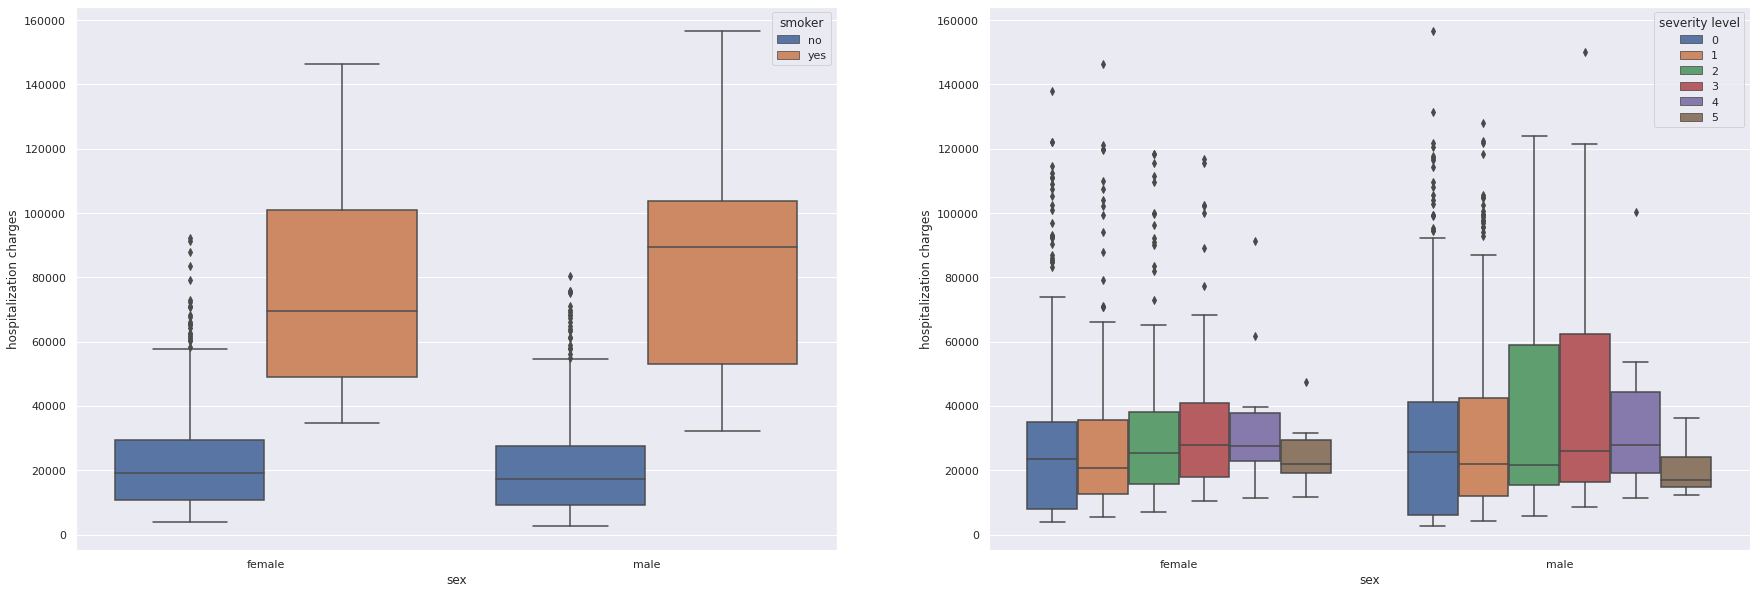

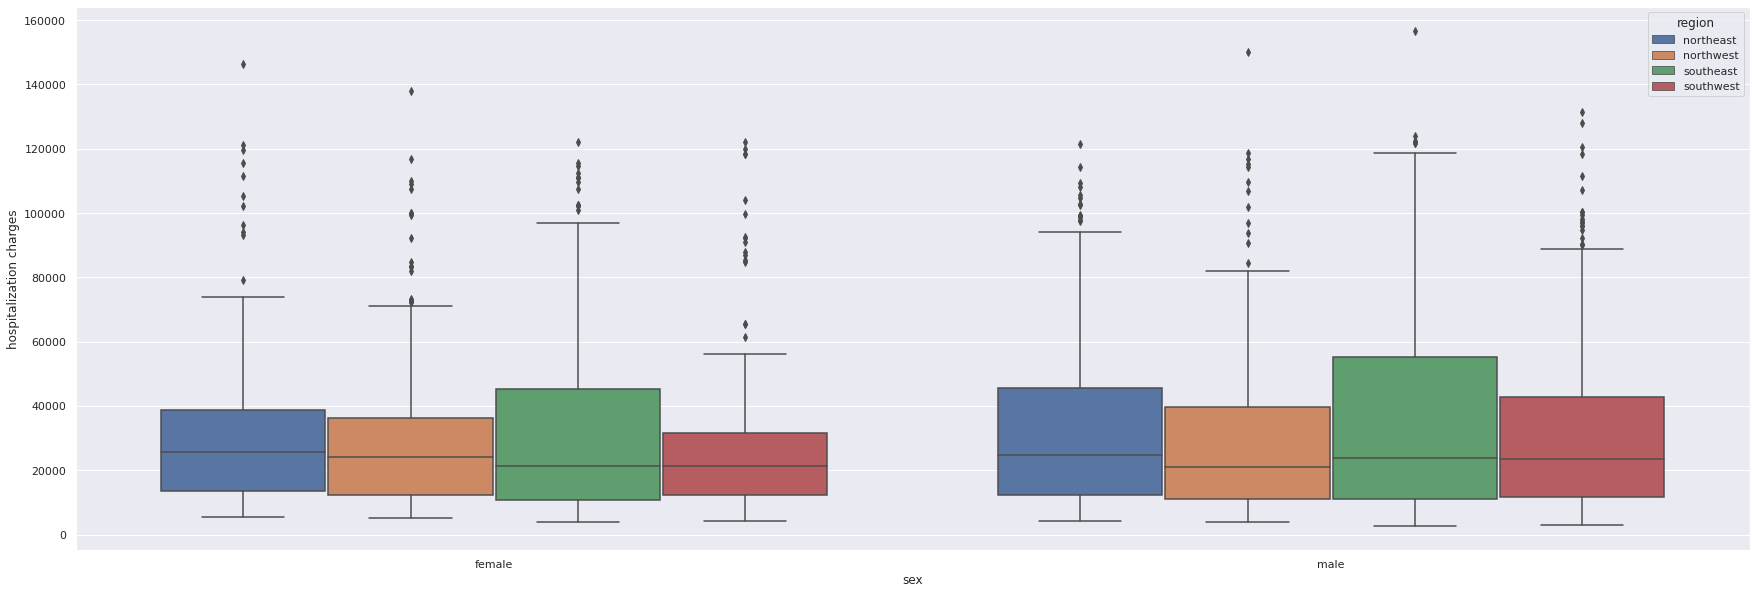

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

sns.boxplot(y=target, x='sex', hue='smoker', data=df, ax=axs[0])
sns.boxplot(y=target, x='sex', hue='severity level', data=df, ax=axs[1])
plt.show()
plt.figure(figsize=(30, 10))
sns.boxplot(y=target, x='sex', hue='region', data=df)
plt.show()

**Observations**

- Male smoker patients have high hospitalization charges as compared to Female smoker patients.
- Female with severity level 3 & 4 will have high hospitalization charges while male with severity level 0 & 4 will have almost similary hospitalization charges.

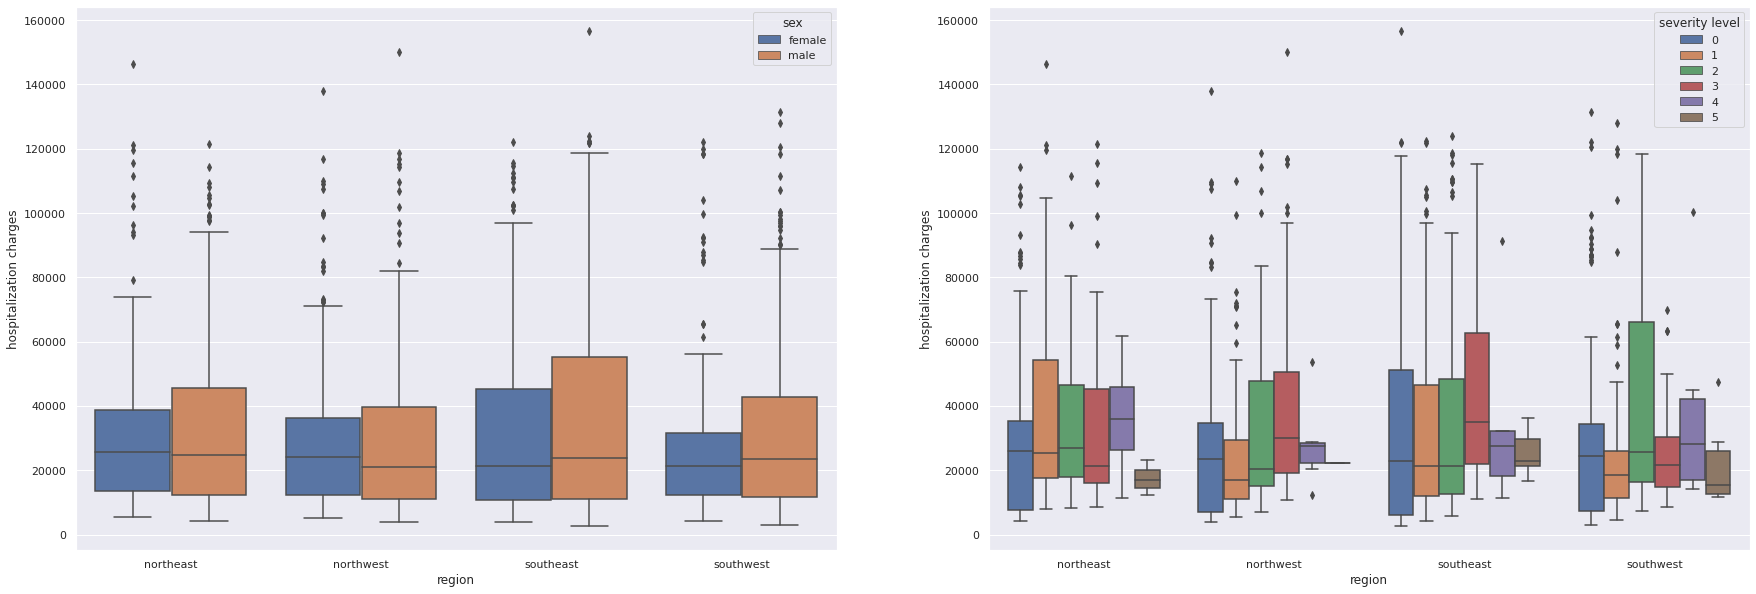

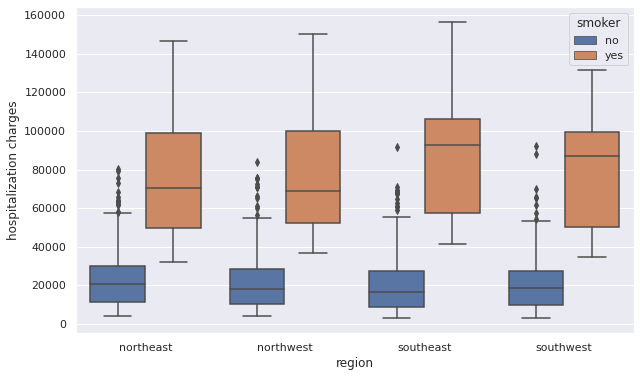

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

sns.boxplot(y=target, x='region', hue='sex', data=df, ax=axs[0])
sns.boxplot(y=target, x='region', hue='severity level', data=df, ax=axs[1])
plt.show()
plt.figure(figsize=(10,6))
sns.boxplot(y=target, x='region', hue='smoker', data=df)
plt.show()

**Observations**
- male patients in southweat & southeast regions will have slightly higher hospitalization charges as compare females while female patients in northweat & northeast will have slightly higher hospitalization charges as compared to male patients.
- smoker patients living in southwest & southeast regions will have high hospitalization charges as compared to smoker patients living in north regions.
- Patients living in southwest & northeast and haveseverity level-4 will have higherhospitalization charges as compared to other severity level patients
- Patients living in southeast & northwest and haveseverity level-3 will have higherhospitalization charges as compared to other severity level patients

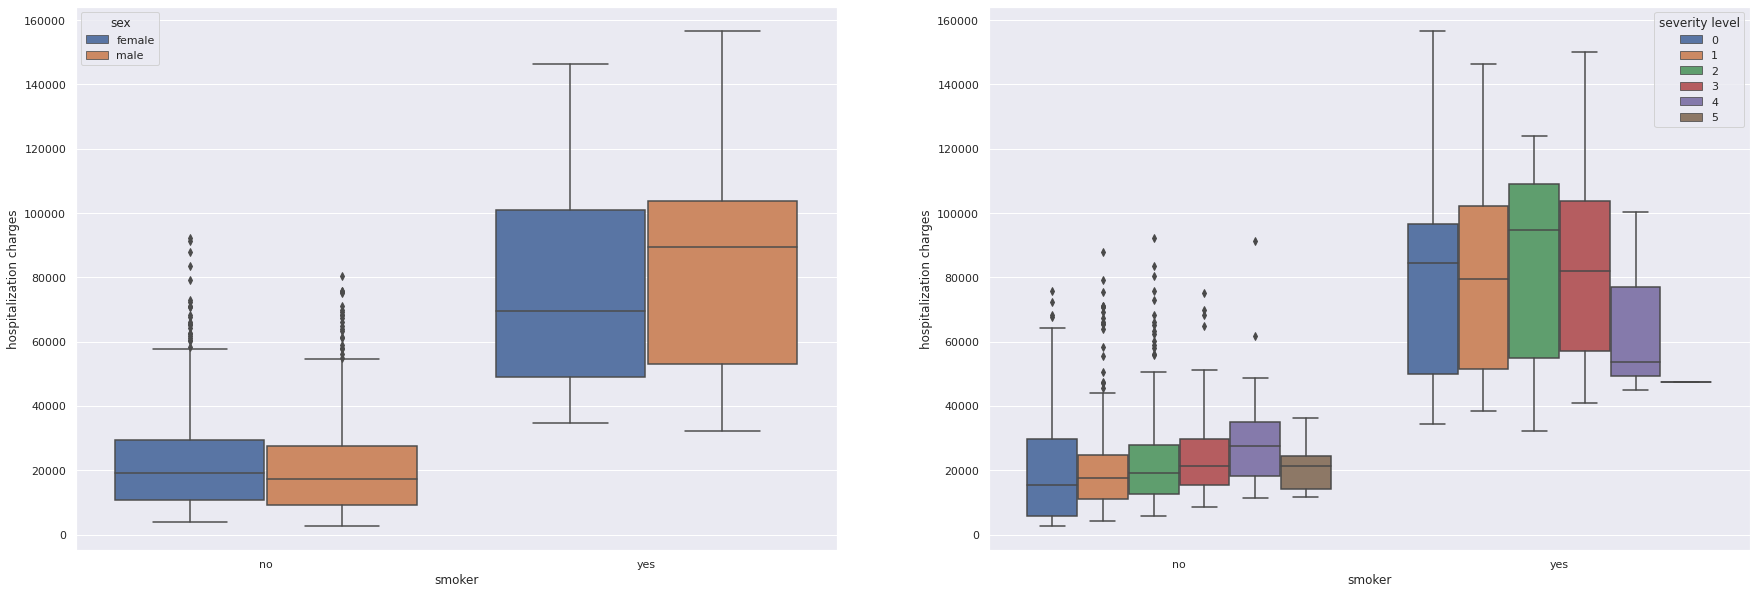

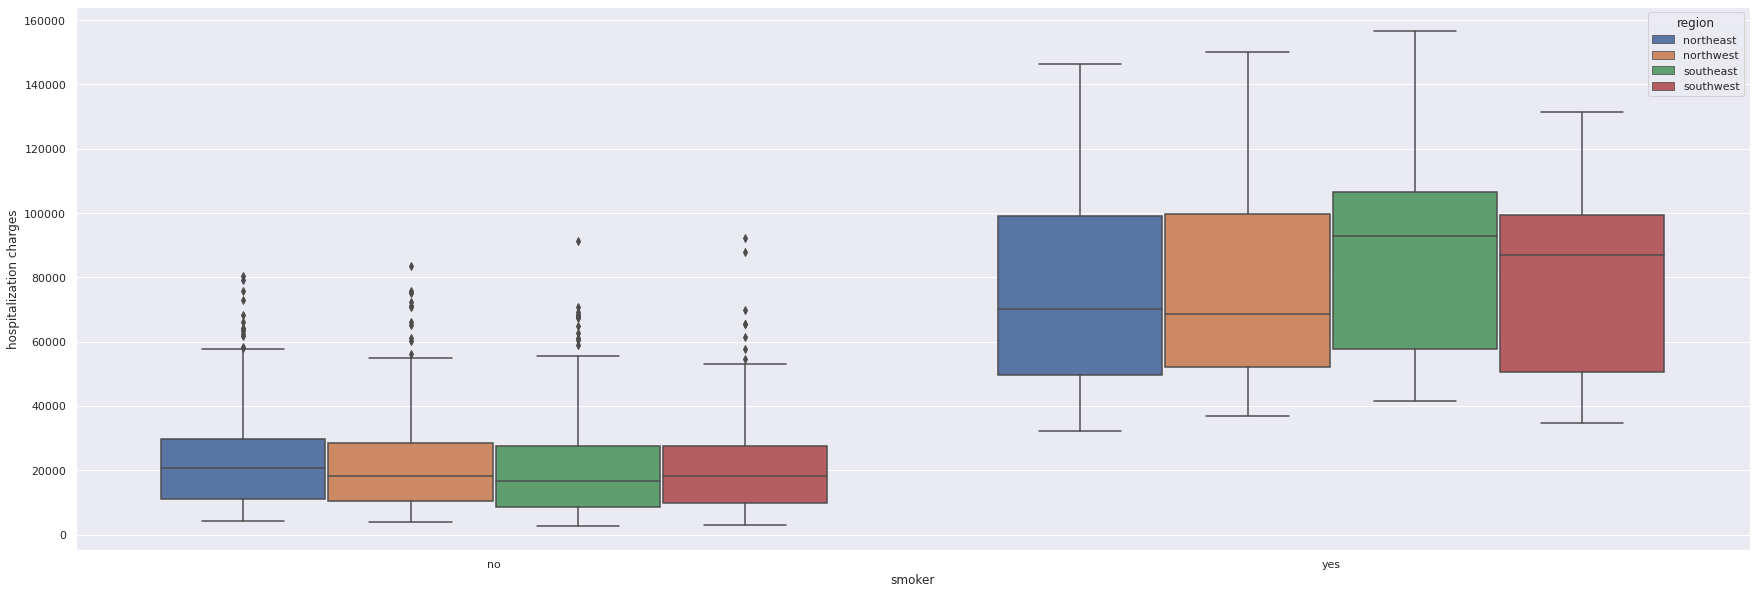

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

sns.boxplot(y=target, x='smoker', hue='sex', data=df, ax=axs[0])
sns.boxplot(y=target, x='smoker', hue='severity level', data=df, ax=axs[1])
plt.show()
plt.figure(figsize=(30, 10))
sns.boxplot(y=target, x='smoker', hue='region', data=df)
plt.show()

**Observations**
- In smoker patients, patients with severity level - 2 will have higher hospitalization charges as comapred to other severity levels.
- In non-smoker patients, patients with severity level - 4 will have higher hospitalization charges as compared to other severity lavels.
- In smoker patients, patients living in southwest region will have higherhospitalization charges as compared to other regions.

***
***
## **8. Prove (or disprove) that the hospitalization charges of people who do smoking are greater than those who don't?**

In [29]:
df.groupby('smoker')['hospitalization charges'].describe()

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
no,1058.0,21105.423440,15007.155103,2805.0,9971.25,18353.5,28407.75,92277.0
yes,271.0,79588.354244,28461.379883,32074.0,51899.50,85758.0,102342.00,156482.0


Data size is good so we will not check for Normality.

In [30]:
smoker = df[df['smoker']=='yes']['hospitalization charges']
nonsmoker = df[df['smoker']=='no']['hospitalization charges']

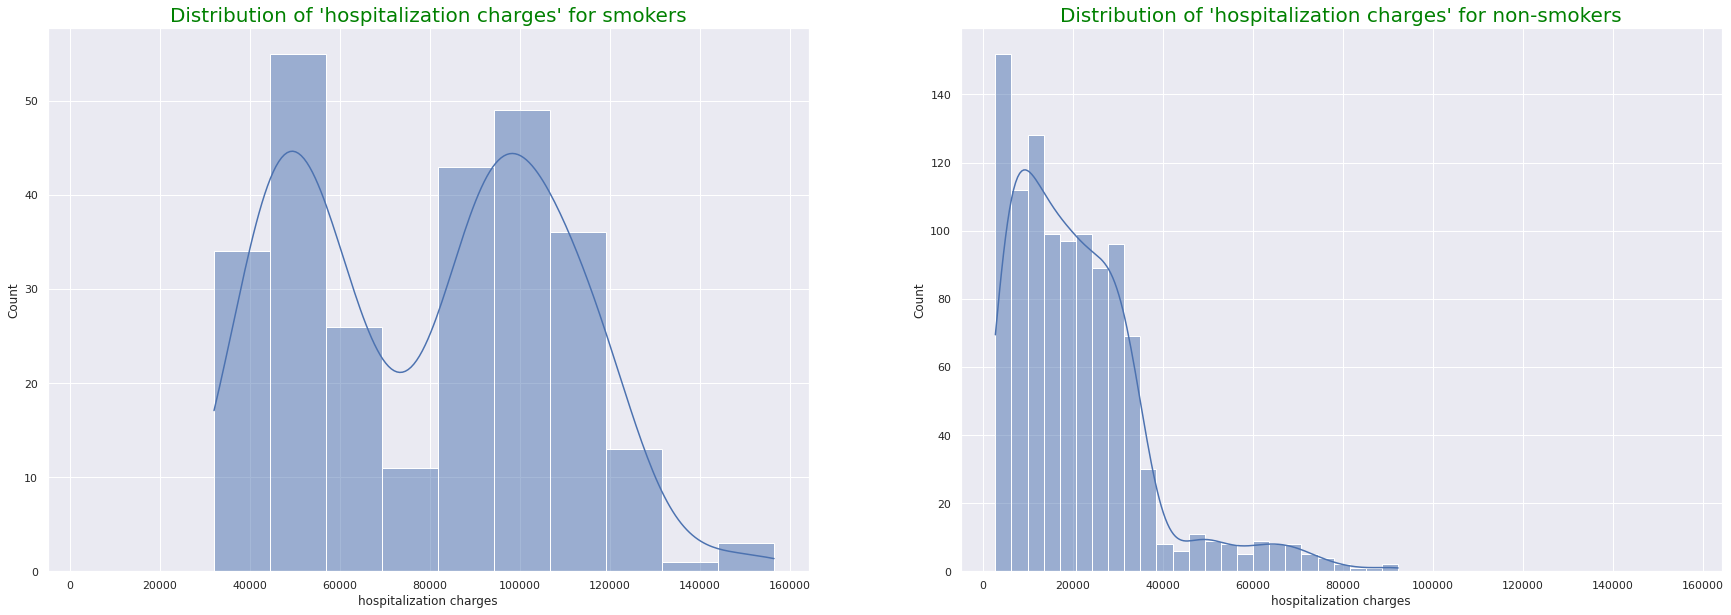

In [31]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(30, 10))
sns.histplot(smoker, kde=True, ax=axes[0]).set_title("Distribution of 'hospitalization charges' for smokers", fontsize=20, color="green")
sns.histplot(nonsmoker, kde=True, ax=axes[1]).set_title("Distribution of 'hospitalization charges' for non-smokers", fontsize=20, color="green")
plt.show()

***
Distributions are right skewed. Hence, trying different transformations to make them roughly Guassian.

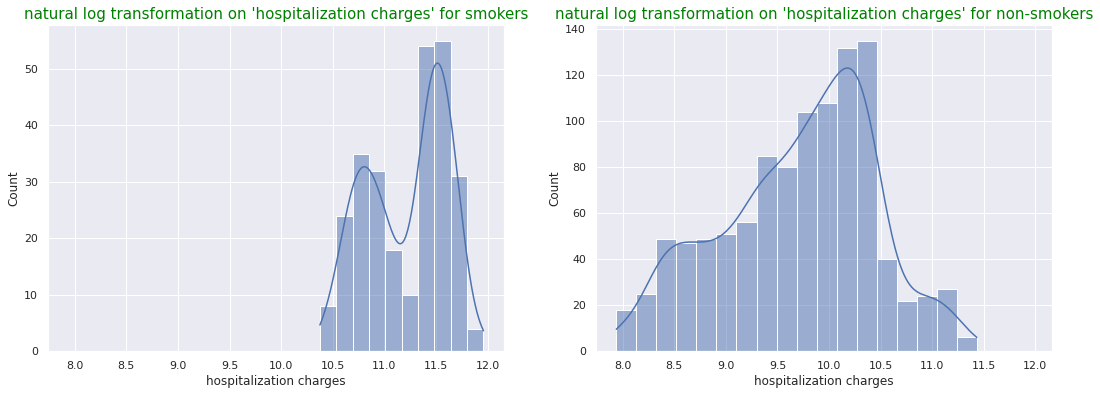

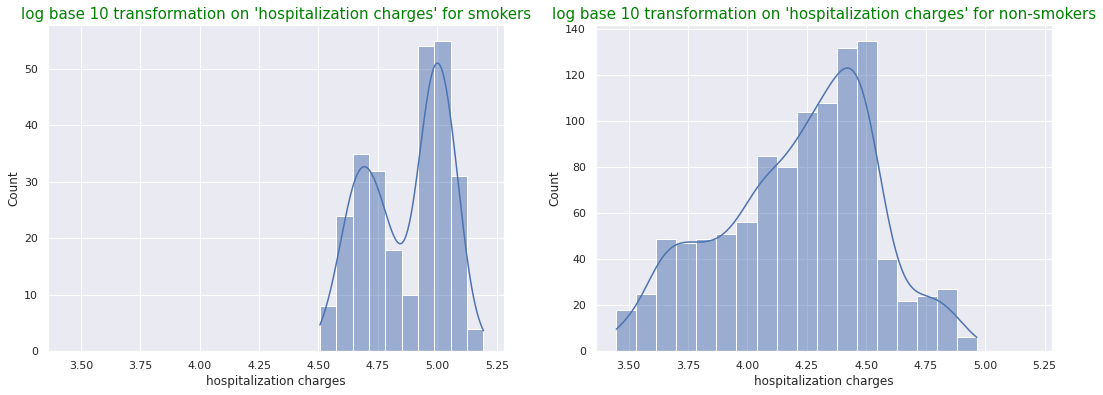

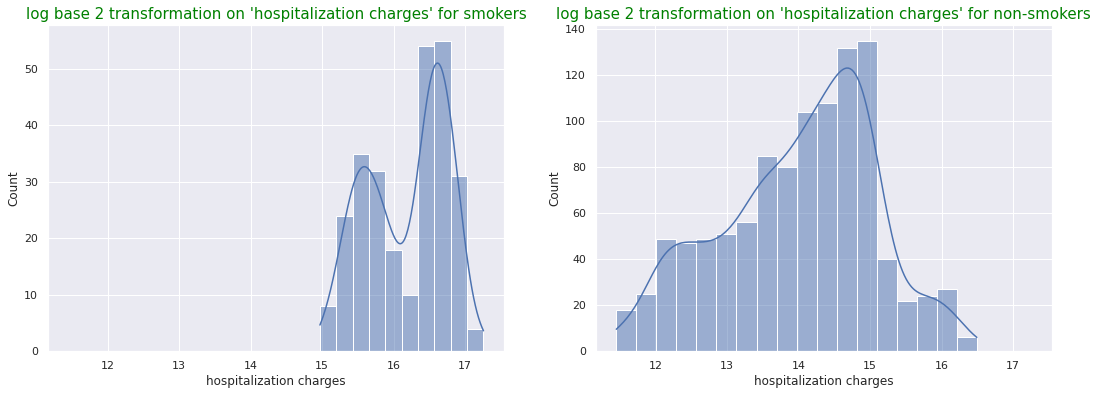

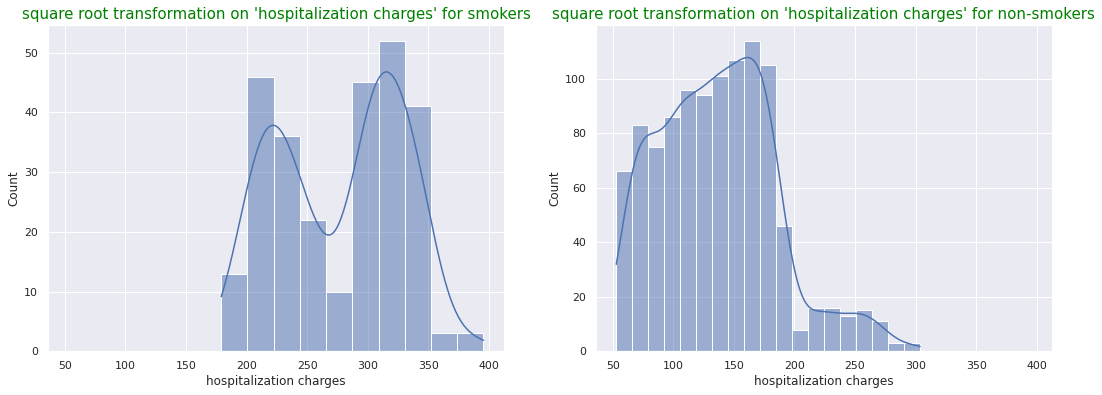

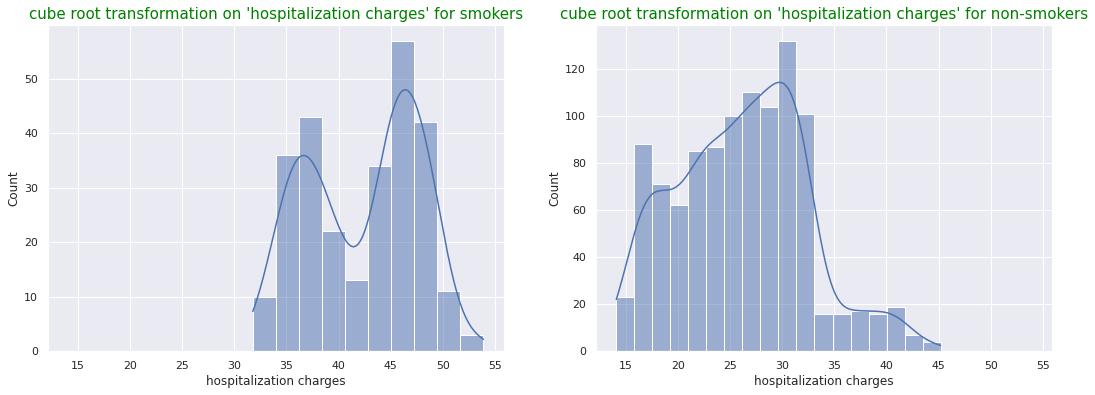

In [32]:
for transformation in right_skew_transformations:
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
    f1 = sns.histplot(smoker.apply(transformation[1]), kde=True, ax=axes[0])
    f1.set_title(f"{transformation[0]} transformation on 'hospitalization charges' for smokers", fontsize=15, color="green")
    f2 = sns.histplot(nonsmoker.apply(transformation[1]), kde=True, ax=axes[1])
    f2.set_title(f"{transformation[0]} transformation on 'hospitalization charges' for non-smokers", fontsize=15, color="green")
    plt.show()

***
Even though, none of the transformations are making data visually look roughly Guassian, still proceeding further for t-test with the existing data since the sample size is significantly large.

In [33]:
np.std(smoker)**2, np.std(nonsmoker)**2

(807061029.8966516, 225001835.95113295)

***
Even though, the variances are not equal, still proceeding further with the t-test since the sample size is significantly large.

***
### 8.1 **Applying Unpaired T-Test**
***

- **H0** = The mean difference for 'hospitalization charges' between unpaired observations for 'smokers' and 'non-smokers' is zero.
- **H1** = The mean difference for 'hospitalization charges' between unpaired observations for 'smokers' is grater than 'non-smokers'.
- **Significance Level (α)** = 0.05

In [34]:
stats.ttest_ind(smoker.sample(100), nonsmoker.sample(100), equal_var=False,  alternative='greater')

Ttest_indResult(statistic=18.65599913248713, pvalue=2.8445228704856066e-41)

In [35]:
stats.ks_2samp(smoker.sample(100), nonsmoker.sample(100))

KstestResult(statistic=0.9, pvalue=4.958889584060123e-43)

***
## Rejected null hypothesis as the p-value is less than the significance level.

***
***
## **9. Prove (or disprove) with statistical evidence that the viral load of females is different from that of males**


In [36]:
male = df[df['sex']=='male']['viral load']
female = df[df['sex']=='female']['viral load']

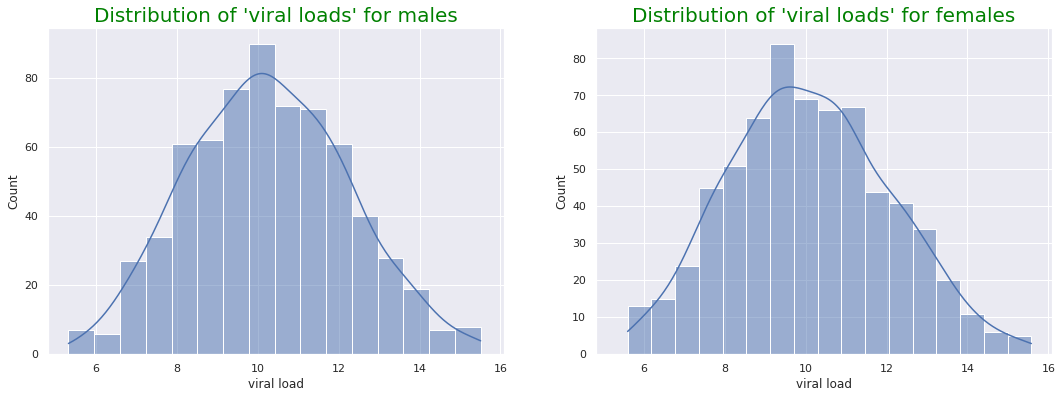

In [37]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
sns.histplot(male, kde=True, ax=axes[0]).set_title("Distribution of 'viral loads' for males", fontsize=20, color="green")
sns.histplot(female, kde=True, ax=axes[1]).set_title("Distribution of 'viral loads' for females", fontsize=20, color="green")
plt.show()

***
Distributions visually look roughly Guassian, so proceeding further with the t-test without any transformations.

In [38]:
np.std(male)**2, np.std(female)**2

(3.849162792604143, 3.9218507956829796)

***
Variances are approximately equal, so proceeding further with the t-test.

***
### 9.1 **Applying Unpaired T-Test**
***
- **H0** = The mean difference for 'viral loads' between unpaired observations for 'males' and 'females' is zero.
- **H1** = The mean difference for 'viral loads' between unpaired observations for 'males' and 'females' is not zero.
- **Significance Level (α/2)** = 0.025

In [39]:
stats.ttest_ind(male.sample(100), female.sample(100), equal_var=True,  alternative='two-sided')

Ttest_indResult(statistic=0.014348161639910775, pvalue=0.9885666632159705)

***
## **Failed to reject null hypothesis as the p-value is higher than significance level, so gender has no role in Viral load**

***
***
## **10. Is the proportion of smoking significantly different across different regions?**



### 10.1 **Chi square test to analyze if the proportion of smoking is significantly different across different regions.**
- **H0: Proportion of smoking is not different across different regions.**
- **H1: Proportion of smoking is different across different regions.**
- **Significance Level (α)** = 0.05


In [40]:
contingency_table = pd.crosstab(df['smoker'],df['region'])
contingency_table

region,northeast,northwest,southeast,southwest
smoker,,,,
no,256,267,268,267
yes,67,58,89,57


***
 Testing assumptions of Chi-Square test.
 1. Categorical Variables = Yes
 2. Independent Observations = Yes
 3. Cells in the contingency table are mutually exclusive = Yes
 4. Values in cells should be greater than 5 = Yes

In [41]:
stat, p, dof, expected = stats.chi2_contingency(contingency_table)
stat, p

(7.41509003066203, 0.05978076201764091)

***
## **Failed to reject null hypothesis as the p-value is higher than significance level.**

***
***
## **11. Is the mean viral load of women with 0 Severity level, 1 Severity level, and 2 Severity level the same? Explain your answer with statistical evidence**



### 11.1 **Anova test to analyze if the mean viral load of women with different severity levels same.**
### **H0: mean viral load is same for women with different severity levels.**
### **H1: mean viral load is not same for women with different severity levels.**
### **Significance Level (α)** = 0.05
***
***

In [42]:
female = df[(df['sex']=='female')]
level_0 = female[female['severity level']==0]['viral load']
level_1 = female[female['severity level']==1]['viral load']
level_2 = female[female['severity level']==2]['viral load']

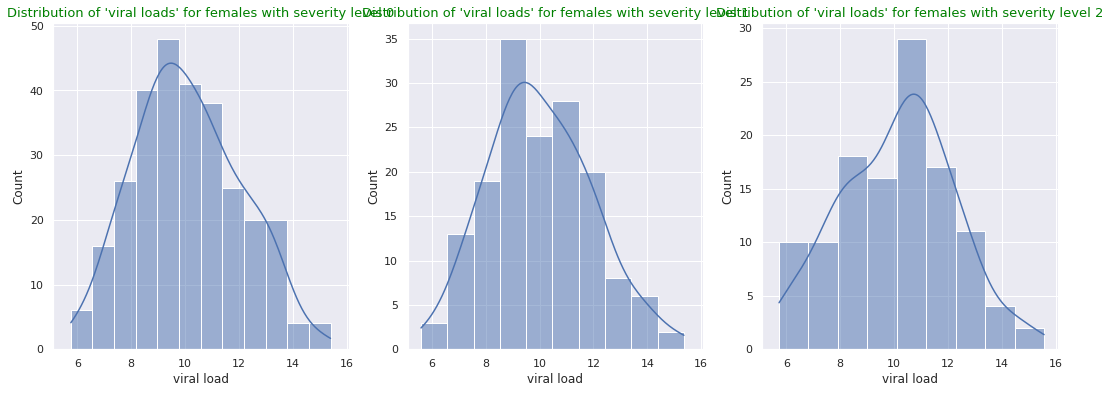

In [43]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(18,6))
sns.histplot(level_0, kde=True, ax=axes[0]).set_title("Distribution of 'viral loads' for females with severity level 0", fontsize=13, color="green")
sns.histplot(level_1, kde=True, ax=axes[1]).set_title("Distribution of 'viral loads' for females with severity level 1", fontsize=13, color="green")
sns.histplot(level_2, kde=True, ax=axes[2]).set_title("Distribution of 'viral loads' for females with severity level 2", fontsize=13, color="green")
plt.show()

***
Distributions visually look roughly Guassian, so proceeding further with the Anova test without any transformations.

In [44]:
np.std(level_0)**2, np.std(level_1)**2, np.std(level_2)**2

(3.8440222499517747, 3.697740426213747, 4.353871415004748)

***
Even though, the variances are not equal, still proceeding further with the Anova test.

In [45]:
stats.f_oneway(level_0, level_1, level_2)

F_onewayResult(statistic=0.11717048239408508, pvalue=0.8894553469550055)

In [46]:
stats.kruskal(level_0, level_1, level_2)

KruskalResult(statistic=0.38729287428068637, pvalue=0.8239491706000333)

***
## **Failed to reject null hypothesis as the p-value is higher than significance level.**

### 11.2 **Assumptions Test for Anova**

Shapiro-Wilk’s test We will test the :
 - null hypothesis: viral load follows normal distribution

against the

- alternative hypothesis: viral load doesn't follow normal distribution

In [47]:
df_female_severe=df[df['sex']=='female'].loc[df[df['sex']=='female']['severity level']<=2]

In [48]:
from scipy.stats import shapiro
# find the p-value
w, p_value = shapiro(df_female_severe['viral load'])
print('The p-value is', p_value)

The p-value is 0.02440580539405346


## Null Hypothesis is False. i.e. it doesn't follows normal distribution.We can also test this using EDA.

### 11.3 **Shapiro Test - Another Test for Normality**
- Same Null & alternate hypothesis as above.
- Since previous test was not normal. we will convert to Log-normal and check.


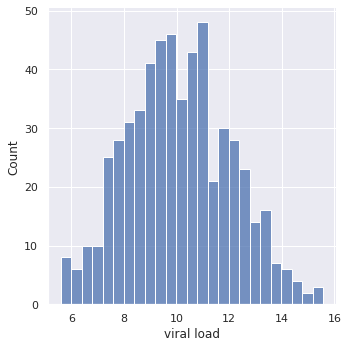

In [49]:
sns.displot(df_female_severe['viral load'],bins=25) 

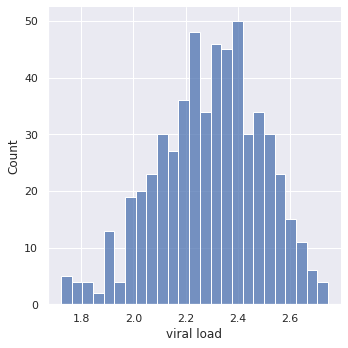

In [50]:
# log transformation to make it normal distribution
import numpy as np
sns.displot(np.log(df_female_severe['viral load']),bins=25) 

In [51]:
from scipy.stats import shapiro
# find the p-value
w, p_value = shapiro(np.log(df_female_severe['viral load']) )
print('The p-value is', p_value)

The p-value is 0.0008664231863804162


Even after we have converted to log normal. it is still not Normal.

## Anova is not very sensitive to moderate deviations from normality. so we will continue doing the Analysis. This is because when you take a large number of random samples from a population, the means of those samples are approximately normally distributed even when the population is not normal

### 11.4 **Levene’s test**

- **null hypothesis** : All the viral load variances are equal

against the

- **alternative hypothesis** : At least one variance is different from the rest.

In [52]:
from scipy.stats import levene
statistic, p_value = levene(df_female_severe[df_female_severe['severity level']==0]['viral load'].sample(106),
 df_female_severe[df_female_severe['severity level']==1]['viral load'].sample(106),
 df_female_severe[df_female_severe['severity level']==2]['viral load'].sample(106))
# find the p-value
print('The p-value is ',p_value)

The p-value is  0.6356184760054245


## It is high means Null hypothesis is true. All the viral load variances are equal. It was evident from Above also where we saw that std. dev was close to each other.so Variance will also be close

***
***
## **12. Business Insights & Recommendations**


### 12.1 **Business Insights**

1. Non-smokers are approximately 5 times more in number than Smokers.
2. The number of patients with a Severity Level of 1 is less than the number of patients with a Severity Level of 0.
3. The number of patients with Severity Level 2 is less than the number of patients with Severity Level 1.
4. The number of patients with Severity Level 3 is less than the number of patients with Severity Level 2.
5. The number of patients with Severity Levels 4 and 5 is less than the number of patients with Severity Level 3.
6. The majority of the patients have low Hospitalization Charges.
7. Smokers have significantly higher Hospitalization Charges than Non-smokers.
8. There is no significant difference between Viral Loads for Males and Females.
9. The proportion of Smokers is significantly different across different regions.
10. The mean viral load is the same for women with different severity levels.
11. Patients with Severity Levels 4 and 5 are less than patients with Severity Levels 0, 1, 2, and 3.


### **12.2 Recommendations.**
1. The smoker column should be used as a variable in predicting the Hospitalization Charges.
2. The gender column should not be used as a variable in predicting the Viral Loads.
3. The smoker column should be used as a variable in predicting the Hospitalizations across different regions.
4. The severity Level column should not be used as a variable in predicting the Viral Loads for Women.